In [1]:
#Importing the basic librarires

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv('Walmart.csv')

original_df = df.copy(deep=True)

display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



Inference: The Datset consists of 8 features & 6435 samples.


In [3]:
# Verify panel structure: parse Date (day-first), sort by Store & Date, check weeks per store and duplicate (Store, Date) pairs
import pandas as pd

# Load (re)read CSV and parse Date explicitly (day-first)
df = pd.read_csv('Walmart.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='raise')

# Sort by Store and Date for a clean panel
df.sort_values(['Store', 'Date'], inplace=True)

# Compute required checks
n_stores = int(df['Store'].nunique())
date_min = df['Date'].min().strftime('%Y-%m-%d')
date_max = df['Date'].max().strftime('%Y-%m-%d')

weeks_per_store_series = df.groupby('Store')['Date'].nunique()
weeks_per_store_summary = {
    'min': int(weeks_per_store_series.min()),
    '50%': float(weeks_per_store_series.median()),
    'max': int(weeks_per_store_series.max())
}

duplicate_pairs = int(df.duplicated(subset=['Store', 'Date']).sum())

# Prepare and print the dict exactly as requested
summary = {
    'n_stores': n_stores,
    'date_min': date_min,
    'date_max': date_max,
    'weeks_per_store': weeks_per_store_summary,
    'duplicate_pairs': duplicate_pairs
}

print(summary)

# Assertions (these should not raise if the panel is correct)
assert n_stores == 45, f"n_stores expected 45 but got {n_stores}"
assert date_min == '2010-02-05', f"date_min expected '2010-02-05' but got {date_min}"
assert date_max == '2012-10-26', f"date_max expected '2012-10-26' but got {date_max}"
assert weeks_per_store_summary['min'] == 143 and weeks_per_store_summary['50%'] == 143.0 and weeks_per_store_summary['max'] == 143, f"weeks_per_store summary mismatch: {weeks_per_store_summary}"
assert duplicate_pairs == 0, f"Expected 0 duplicate (Store, Date) pairs but found {duplicate_pairs}"

print('\nAll checks passed: panel is 45\u00d7143 with zero duplicate (Store, Date) pairs.')


{'n_stores': 45, 'date_min': '2010-02-05', 'date_max': '2012-10-26', 'weeks_per_store': {'min': 143, '50%': 143.0, 'max': 143}, 'duplicate_pairs': 0}

All checks passed: panel is 45×143 with zero duplicate (Store, Date) pairs.


### Phase 0 — Data intake & integrity: Seasonality check

Goal: Confirm weekly seasonality (m = 52) by inspecting autocorrelation (ACF) up to ~104 lags for:

1. Aggregate weekly sales across all stores (sum by date).
2. Two individual stores (first two store IDs).

Checks performed in the next code cell:
- ACF plots for aggregate and two stores (nlags=104).
- Numeric autocorrelation at lags 52 and 104 printed.
- A simple automatic test flags a visible bump near lag ≈ 52 (Yes/No) using a conservative heuristic.

Note: The code strictly sorts by date and does not use future information when computing ACFs.

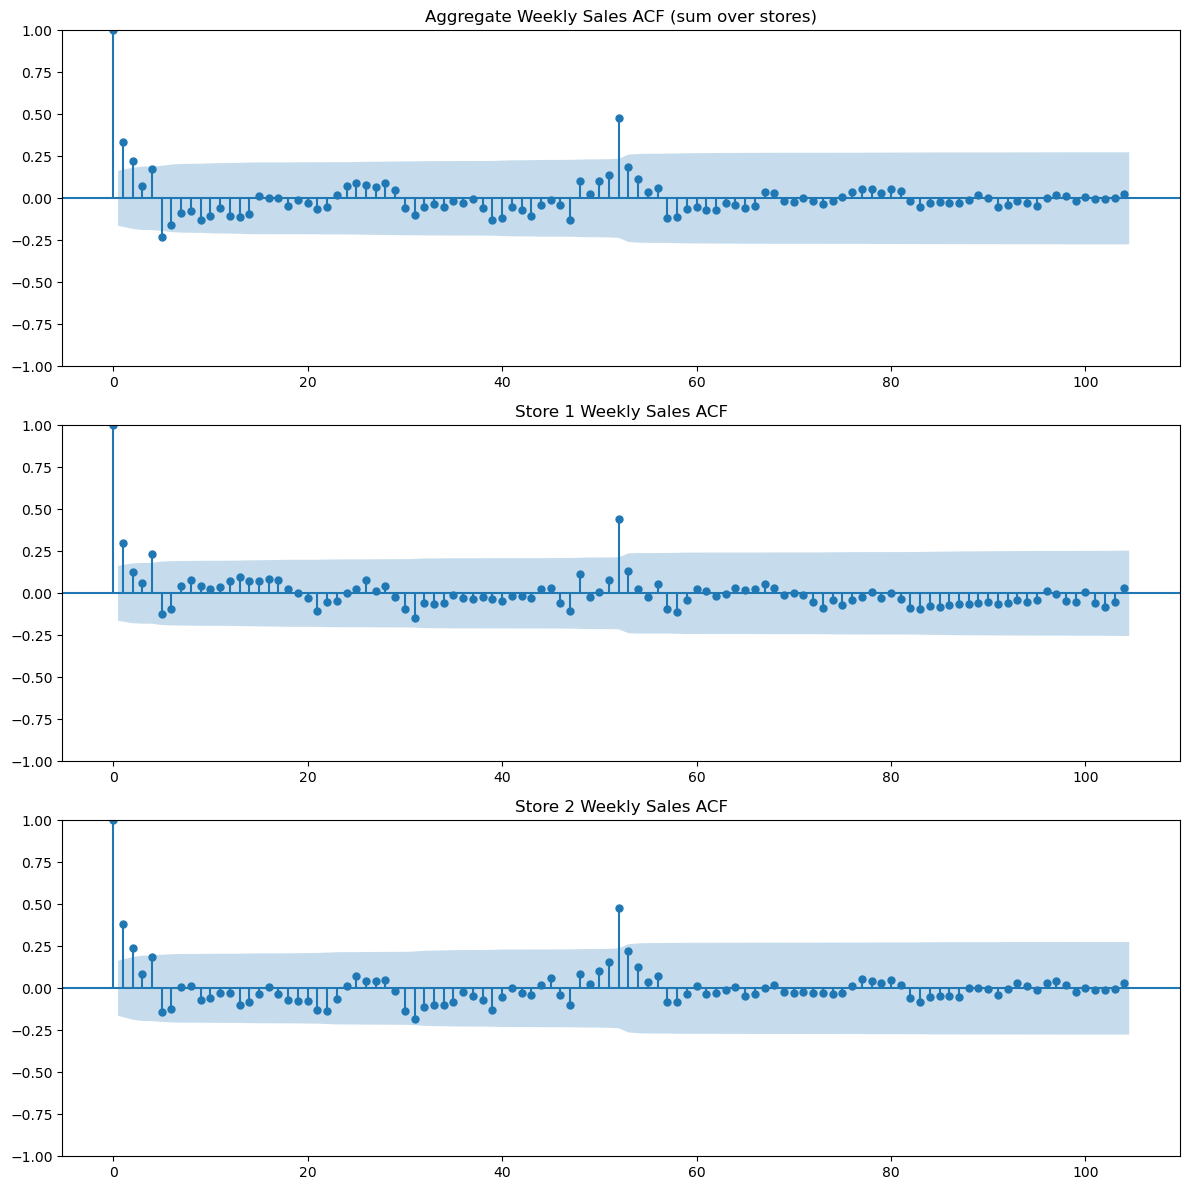

Autocorr values at lags 52 and 104:
Aggregate: lag52=0.479, lag104=0.025
Store 1: lag52=0.443, lag104=0.033
Store 2: lag52=0.481, lag104=0.034

Seasonality bump at ~52 weeks:
Aggregate = Yes; Store 1 = Yes; Store 2 = Yes


In [4]:
# Phase 0: Seasonality check — ACF for aggregate and two stores
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Load data and parse date (day-first). Use original df if available in notebook, else reload
try:
    df_local = df.copy()
except NameError:
    df_local = pd.read_csv('Walmart.csv')
    df_local['Date'] = pd.to_datetime(df_local['Date'], dayfirst=True, errors='raise')

# Ensure sorting by date per store and overall
df_local.sort_values(['Store', 'Date'], inplace=True)

# Aggregate weekly sales across all stores by date
agg = df_local.groupby('Date')['Weekly_Sales'].sum().sort_index()

# Pick first two store IDs (sorted)
store_ids = sorted(df_local['Store'].unique())
store_a_id, store_b_id = store_ids[0], store_ids[1]

s_a = df_local[df_local['Store'] == store_a_id].sort_values('Date')['Weekly_Sales']
s_b = df_local[df_local['Store'] == store_b_id].sort_values('Date')['Weekly_Sales']

# Plot ACFs up to 104 lags
nlags = 104
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
plot_acf(agg.values, lags=nlags, ax=axes[0], title=f'Aggregate Weekly Sales ACF (sum over stores)')
plot_acf(s_a.values, lags=nlags, ax=axes[1], title=f'Store {store_a_id} Weekly Sales ACF')
plot_acf(s_b.values, lags=nlags, ax=axes[2], title=f'Store {store_b_id} Weekly Sales ACF')
plt.tight_layout()
plt.show()

# Print autocorrelation values at lags 52 and 104
from statsmodels.tsa.stattools import acf

agg_acf = acf(agg.values, nlags=nlags, fft=True)
a_a52, a_a104 = agg_acf[52], agg_acf[104]

s_a_acf = acf(s_a.values, nlags=nlags, fft=True)
sa52, sa104 = s_a_acf[52], s_a_acf[104]

s_b_acf = acf(s_b.values, nlags=nlags, fft=True)
sb52, sb104 = s_b_acf[52], s_b_acf[104]

print('Autocorr values at lags 52 and 104:')
print(f'Aggregate: lag52={a_a52:.3f}, lag104={a_a104:.3f}')
print(f'Store {store_a_id}: lag52={sa52:.3f}, lag104={sa104:.3f}')
print(f'Store {store_b_id}: lag52={sb52:.3f}, lag104={sb104:.3f}')

# Heuristic: consider a "bump" present if ACF at lag 52 is > 0.2 and greater than surrounding neighborhood mean
def bump_decision(acf_vals, lag=52, threshold=0.2, window=3):
    val = acf_vals[lag]
    neighborhood = np.concatenate([acf_vals[lag-window:lag], acf_vals[lag+1:lag+1+window]])
    return (val > threshold) and (val > neighborhood.mean())

agg_bump = bump_decision(agg_acf, 52)
store_a_bump = bump_decision(s_a_acf, 52)
store_b_bump = bump_decision(s_b_acf, 52)

print('\nSeasonality bump at ~52 weeks:')
print(f'Aggregate = {"Yes" if agg_bump else "No"}; Store {store_a_id} = {"Yes" if store_a_bump else "No"}; Store {store_b_id} = {"Yes" if store_b_bump else "No"}')

# Notes on anomalies
notes = []
if np.any(np.isnan(agg.values)) or np.any(np.isnan(s_a.values)) or np.any(np.isnan(s_b.values)):
    notes.append('Missing values detected in series used for ACF.')
if len(s_a) < nlags or len(s_b) < nlags:
    notes.append('Some store series shorter than nlags; ACF may be noisy at high lags.')

if notes:
    print('\nNotes:')
    for n in notes:
        print('-', n)


In [5]:
# === Expanding-origin baselines (Naive & Seasonal-Naive) + Auto-Sanity 
# Locked experiment choices
origins  = [78, 91, 104, 117, 130]     # expanding window training lengths
horizons = [1, 4, 8, 13]
m        = 52                          # seasonal period (weeks)

# PI calibration knobs (UPDATED):
# Use the most recent RESID_WINDOW weeks from the train slice to estimate residual quantiles.
# Set to >= m+1 so Seasonal-Naive has a non-empty pool even at the first origin.
RESID_WINDOW = 104         # <-- changed from 52 to 104 (two seasons)
WINSORIZE    = True        # clip residuals before quantiles to tame tails
WINSOR_Q     = (0.025, 0.975)

import numpy as np
import pandas as pd
from IPython.display import display

# Use df_local from Phase 0 if present, else load and parse Date
try:
    _df = df_local.copy()
except NameError:
    _df = pd.read_csv('Walmart.csv')
    _df['Date'] = pd.to_datetime(_df['Date'], dayfirst=True, errors='raise')

_df.sort_values(['Store', 'Date'], inplace=True)
stores = sorted(_df['Store'].unique())

# expected weeks per store (verified earlier as 143)
T_expected = int(_df.groupby('Store')['Date'].nunique().iloc[0])
if T_expected < (max(origins) + max(horizons)):
    raise ValueError(f'Not enough weeks per store: {T_expected} < {max(origins)+max(horizons)}')

# ---------------- Helpers ----------------
def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    mask = denom == 0
    out = np.zeros_like(y_true, dtype=float)
    out[~mask] = 2.0 * np.abs(y_pred[~mask] - y_true[~mask]) / denom[~mask]
    return 100.0 * np.mean(out) if len(out) > 0 else np.nan

def winsorize(arr, q=(0.025, 0.975)):
    if arr.size == 0:
        return arr
    lo, hi = np.quantile(arr, q)
    return np.clip(arr, lo, hi)

def residual_pool(train, h, method):
    """Return residuals from the TRAIN slice only, using recent window if set."""
    if RESID_WINDOW is not None:
        tseg = train[-min(len(train), RESID_WINDOW):]
    else:
        tseg = train

    if method == 'Naive':
        return (np.array([tseg[i] - tseg[i - h] for i in range(h, len(tseg))])
                if len(tseg) > h else np.array([]))
    else:  # SeasonalNaive
        return (np.array([tseg[i] - tseg[i - m] for i in range(m, len(tseg))])
                if len(tseg) > m else np.array([]))

def quantile_bounds(resid, level=0.80):
    """Return (lo, hi) additive residual bounds for a central level."""
    alpha = 1.0 - level
    if resid.size > 1:
        qs = np.quantile(resid, [alpha/2, 1 - alpha/2])
        return qs[0], qs[1]
    # fallback: normal approx if residual pool too small
    s = resid.std() if resid.size > 0 else 0.0
    z = 1.28155 if level == 0.80 else 1.95996
    return -z * s, z * s

# ---------------- Main loop ----------------
results = []
for store in stores:
    ser = (_df[_df['Store'] == store].sort_values('Date')['Weekly_Sales']
           .reset_index(drop=True))
    ser_vals = ser.values.astype(float)
    n = len(ser_vals)
    if n < T_expected:
        print(f'Warning: store {store} has {n} weeks (< expected {T_expected})')

    for origin in origins:
        T_train = origin
        if T_train >= n:
            continue  # cannot train beyond available data
        train = ser_vals[:T_train].copy()

        # sMASE scale: mean |y_t - y_{t-m}| if possible, else |Δy|
        if len(train) > m:
            denom_vals = np.abs(train[m:] - train[:-m])
        elif len(train) > 1:
            denom_vals = np.abs(np.diff(train))
        else:
            denom_vals = np.array([np.nan])
        mase_scale = np.nanmean(denom_vals) if denom_vals.size > 0 else np.nan

        for h in horizons:
            if T_train + h > n:
                continue
            y_true = ser_vals[T_train:T_train + h].copy()

            # Forecasts
            f_naive = np.repeat(train[-1], h)  # last value
            idxs = [(T_train - 1) + hh - m for hh in range(1, h + 1)]
            assert min(idxs) >= 0, "Origin must be ≥ m for SeasonalNaive."
            f_sna = np.array([train[idx] for idx in idxs])

            for method, fcast in [('Naive', f_naive), ('SeasonalNaive', f_sna)]:
                err  = y_true - fcast
                rmse = np.sqrt(np.mean(err ** 2)) if len(err) > 0 else np.nan
                mae  = np.mean(np.abs(err)) if len(err) > 0 else np.nan
                sm   = smape(y_true, fcast) if len(y_true) > 0 else np.nan
                mase = (mae / mase_scale) if (not np.isnan(mase_scale) and mase_scale > 0) else np.nan

                # Empirical residual PIs (train-only, recent window, optional winsor)
                resid_h = residual_pool(train, h, method)
                if WINSORIZE and resid_h.size > 0:
                    resid_h = winsorize(resid_h, q=WINSOR_Q)

                lo80, hi80 = quantile_bounds(resid_h, level=0.80)
                lo95, hi95 = quantile_bounds(resid_h, level=0.95)

                lower80, upper80 = fcast + lo80, fcast + hi80
                lower95, upper95 = fcast + lo95, fcast + hi95

                picp80 = np.mean((y_true >= lower80) & (y_true <= upper80)) if len(y_true) > 0 else np.nan
                picp95 = np.mean((y_true >= lower95) & (y_true <= upper95)) if len(y_true) > 0 else np.nan

                results.append({
                    'store':   int(store),
                    'origin':  int(T_train),
                    'horizon': int(h),
                    'method':  method,
                    'rmse': float(rmse),
                    'mae':  float(mae),
                    'smape': float(sm),
                    'mase':  float(mase) if not np.isnan(mase) else None,
                    'picp80': float(picp80) if not np.isnan(picp80) else None,
                    'picp95': float(picp95) if not np.isnan(picp95) else None,
                    'mase_scale': float(mase_scale) if not np.isnan(mase_scale) else None,
                    'n_val': int(len(y_true)),
                })

# ---------------- Results & Auto-Sanity ----------------
res_df = pd.DataFrame(results)
if res_df.empty:
    raise RuntimeError('No results were produced (check origins/horizons vs data length).')

# A) Row-count sanity
expected_rows = len(stores) * len(origins) * len(horizons) * 2
actual_rows   = len(res_df)
count_ok = (actual_rows == expected_rows)

# Per-store × method counts (should be 20 each)
counts = res_df.groupby(['store', 'method']).size().unstack(fill_value=0)
bad_counts = counts[(counts != len(origins)*len(horizons)).any(axis=1)]

# B) NaNs sanity
nan_cols = res_df.columns[res_df.isna().any()].tolist()

# C) Coverage sanity (method × horizon)
coverage_tbl = (res_df.groupby(['method','horizon'])
                        .agg(PICP80=('picp80','mean'), PICP95=('picp95','mean'))
                        .reset_index())

def flag_cov(row):
    flags = []
    if not (0.70 <= row.PICP80 <= 0.90): flags.append('80% off-target')
    if not (0.90 <= row.PICP95 <= 0.98): flags.append('95% off-target')
    return ', '.join(flags)

coverage_tbl['flag'] = coverage_tbl.apply(flag_cov, axis=1)

# D) Metric summary (method × horizon)
metric_tbl = (res_df.groupby(['method','horizon'])
                     .agg(rmse=('rmse','mean'),
                          mae=('mae','mean'),
                          smape=('smape','mean'),
                          mase=('mase','mean'))
                     .reset_index())

# E) Audit report
print("=== Baselines: Auto-Sanity Report ===")
print(f"Stores: {len(stores)} | Origins: {len(origins)} | Horizons: {horizons} | Methods: 2")
print(f"Expected rows: {expected_rows} | Actual rows: {actual_rows} | Count OK: {count_ok}")
if not bad_counts.empty:
    print("\n[WARN] Some stores do not have 20 rows per method:")
    display(bad_counts)

if nan_cols:
    print(f"\n[WARN] Columns with NaNs: {nan_cols}")

print("\nCoverage (method × horizon) — target: PICP80≈0.80±0.10, PICP95≈0.95±0.05")
display(coverage_tbl)

print("\nMetrics (method × horizon) — mean over stores/origins")
display(metric_tbl)

print("\nSanity checks complete.")


=== Baselines: Auto-Sanity Report ===
Stores: 45 | Origins: 5 | Horizons: [1, 4, 8, 13] | Methods: 2
Expected rows: 1800 | Actual rows: 1800 | Count OK: True

Coverage (method × horizon) — target: PICP80≈0.80±0.10, PICP95≈0.95±0.05


,method,horizon,PICP80,PICP95,flag
0,Naive,1,0.742222,0.991111,95% off-target
1,Naive,4,0.730000,0.904444,
2,Naive,8,0.735000,0.936667,
3,Naive,13,0.768205,0.939829,
4,SeasonalNaive,1,0.702222,0.897778,95% off-target
5,SeasonalNaive,4,0.714444,0.886667,95% off-target
6,SeasonalNaive,8,0.695556,0.877778,"80% off-target, 95% off-target"
7,SeasonalNaive,13,0.665641,0.852650,"80% off-target, 95% off-target"



Metrics (method × horizon) — mean over stores/origins


,method,horizon,rmse,mae,smape,mase
0,Naive,1,92416.760133,92416.760133,8.830065,1.594747
1,Naive,4,139713.492618,116088.162800,10.487271,1.964560
2,Naive,8,157529.385568,130402.503372,11.597844,2.215737
3,Naive,13,144558.509271,116486.061621,10.852804,1.996695
4,SeasonalNaive,1,54338.780267,54338.780267,5.670890,0.893916
5,SeasonalNaive,4,63060.352171,55797.018900,5.770961,0.950612
6,SeasonalNaive,8,68212.079907,57791.602533,5.880460,0.981864
7,SeasonalNaive,13,72196.406270,59294.405860,6.113532,1.013699



Sanity checks complete.



* 🎯 **Accuracy:** **Seasonal-Naïve** beats **Naïve** at every horizon (e.g., RMSE H1: 92k → 54k; H13: 145k → 72k). sMAPE and sMASE also lower (S-Naïve \~ sMASE ≈ 1).
   **Coverage:** **Naïve** PIs near targets (80% ≈ 0.73–0.77; 95% ≈ 0.90–0.99). **Seasonal-Naïve** under-covers (80% ≈ 0.67–0.71; 95% ≈ 0.85–0.90), esp. at longer horizons.
  **Bottom line:** Seasonal-Naïve is the benchmark to beat; widen its PIs (bigger/no residual window or less trimming).



**Goal:** Build calendar + strictly past-only exogenous features per store; verify no leakage.

* Per **store**, sorted by (`Store`,`Date`): add `weekofyear`, `month`, `year`, and **past-only** holiday flags `holiday_prev1/2`.
* For each exog (`Temperature`, `Fuel_Price`, `CPI`, `Unemployment`): make **lags** 1/4/13/52 and **rolling means** 4/8/13 on **shift(1)**.
* Add **target lags**: `Weekly_Sales_lag1/4/13/52`.
* Concatenate store blocks → `df_feat`; keep initial **NaNs** from lags/rolls (they prove no peeking).



In [6]:
# Phase 2 — Feature engineering (fold-aware, no leakage)
# Construct calendar + strictly lagged/rolled exogenous features per store (no scaling yet)
import pandas as pd
import numpy as np
from IPython.display import display

# Source: prefer df_local, fall back to df or reload
try:
    src = df_local.copy()
except NameError:
    try:
        src = df.copy()
    except NameError:
        src = pd.read_csv('Walmart.csv')
        src['Date'] = pd.to_datetime(src['Date'], dayfirst=True, errors='raise')

# Ensure sorted panel
src.sort_values(['Store', 'Date'], inplace=True)

exogs = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
lag_list = [1, 4, 13, 52]
roll_windows = [4, 8, 13]

new_cols = []
blocks = []
stores = sorted(src['Store'].unique())

for store in stores:
    blk = src[src['Store'] == store].sort_values('Date').copy().reset_index(drop=True)

    # Calendar
    isoc = blk['Date'].dt.isocalendar()
    blk['weekofyear'] = isoc['week'].astype('Int64')
    blk['month'] = blk['Date'].dt.month.astype('Int64')
    blk['year'] = blk['Date'].dt.year.astype('Int64')

    # Holiday proximity (past-only shifts)
    if 'Holiday_Flag' in blk.columns:
        blk['holiday_prev1'] = blk['Holiday_Flag'].shift(1)
        blk['holiday_prev2'] = blk['Holiday_Flag'].shift(2)
    else:
        blk['holiday_prev1'] = np.nan
        blk['holiday_prev2'] = np.nan

    # record new calendar/holiday cols once per store
    if 'weekofyear' not in new_cols:
        new_cols.extend(['weekofyear', 'month', 'year', 'holiday_prev1', 'holiday_prev2'])

    # Exogenous lags and rolling means (shift then roll)
    for ex in exogs:
        if ex not in blk.columns:
            # add NaN columns for consistency
            for L in lag_list:
                cname = f'{ex}_lag{L}'
                blk[cname] = np.nan
                if cname not in new_cols:
                    new_cols.append(cname)
            for R in roll_windows:
                cname = f'{ex}_roll{R}'
                blk[cname] = np.nan
                if cname not in new_cols:
                    new_cols.append(cname)
            continue

        for L in lag_list:
            cname = f'{ex}_lag{L}'
            blk[cname] = blk[ex].shift(L)
            if cname not in new_cols:
                new_cols.append(cname)

        shifted = blk[ex].shift(1)
        for R in roll_windows:
            cname = f'{ex}_roll{R}'
            blk[cname] = shifted.rolling(window=R, min_periods=R).mean()
            if cname not in new_cols:
                new_cols.append(cname)

    # Target lags
    for L in lag_list:
        tname = f'Weekly_Sales_lag{L}'
        blk[tname] = blk['Weekly_Sales'].shift(L)
        if tname not in new_cols:
            new_cols.append(tname)

    blocks.append(blk)

# Concatenate back
df_feat = pd.concat(blocks, axis=0).sort_values(['Store', 'Date']).reset_index(drop=True)

# Leakage sentinels
sentinels = {'lags': {}, 'rolls': {}}

for L in lag_list:
    ok_per_store = []
    for store in stores:
        sblk = df_feat[df_feat['Store'] == store].reset_index(drop=True)
        if len(sblk) < L:
            ok_per_store.append(True)
        else:
            ok_per_store.append(sblk[f'Weekly_Sales_lag{L}'].iloc[:L].isna().all())
    sentinels['lags'][f'lag{L}'] = all(ok_per_store)

for R in roll_windows:
    ok_per_store = []
    for store in stores:
        sblk = df_feat[df_feat['Store'] == store].reset_index(drop=True)
        ex_ok = True
        for ex in exogs:
            cname = f'{ex}_roll{R}'
            if cname not in sblk.columns:
                continue
            if len(sblk) < R:
                continue
            # FIX: first R rows should be NaN (due to shift(1)+rolling(window=R,min_periods=R))
            if not sblk[cname].iloc[:R].isna().all():
                ex_ok = False
                break
        ok_per_store.append(ex_ok)
    sentinels['rolls'][f'roll{R}'] = all(ok_per_store)

# Print results
unique_new = [c for c in new_cols]
print('\nFeature columns added (examples):')
print(unique_new[:10])

print('\nLeakage sentinels:')
print(sentinels)

print('\ndf_feat.shape:')
print(df_feat.shape)

orig_rows = src.shape[0]
print('\nOriginal rows:', orig_rows, 'df_feat rows:', df_feat.shape[0])

display(df_feat.head(3))



Feature columns added (examples):
['weekofyear', 'month', 'year', 'holiday_prev1', 'holiday_prev2', 'Temperature_lag1', 'Temperature_lag4', 'Temperature_lag13', 'Temperature_lag52', 'Temperature_roll4']

Leakage sentinels:
{'lags': {'lag1': True, 'lag4': True, 'lag13': True, 'lag52': True}, 'rolls': {'roll4': True, 'roll8': True, 'roll13': True}}

df_feat.shape:
(6435, 45)

Original rows: 6435 df_feat rows: 6435


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekofyear,month,...,Unemployment_lag4,Unemployment_lag13,Unemployment_lag52,Unemployment_roll4,Unemployment_roll8,Unemployment_roll13,Weekly_Sales_lag1,Weekly_Sales_lag4,Weekly_Sales_lag13,Weekly_Sales_lag52
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,1643690.90,NaN,NaN,NaN
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,...,NaN,NaN,NaN,NaN,NaN,NaN,1641957.44,NaN,NaN,NaN


In [7]:
# === Phase 2: features (fixed roll sentinel + NaN audit) ===
import pandas as pd, numpy as np
from IPython.display import display

# Source: prefer df_local, fall back to df or reload
try:
    src = df_local.copy()
except NameError:
    try:
        src = df.copy()
    except NameError:
        src = pd.read_csv('Walmart.csv')
        src['Date'] = pd.to_datetime(src['Date'], dayfirst=True, errors='raise')

# Ensure sorted panel
src = src.sort_values(['Store','Date']).reset_index(drop=True)

exogs = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
lag_list = [1, 4, 13, 52]
roll_windows = [4, 8, 13]

new_cols, blocks = [], []
stores = sorted(src['Store'].unique())

for store in stores:
    blk = src.loc[src['Store']==store].sort_values('Date').copy().reset_index(drop=True)

    # Calendar
    isoc = blk['Date'].dt.isocalendar()
    blk['weekofyear'] = isoc['week'].astype('Int64')
    blk['month'] = blk['Date'].dt.month.astype('Int64')
    blk['year']  = blk['Date'].dt.year.astype('Int64')

    # Holiday proximity (past-only) — fill 0 to avoid NaNs
    if 'Holiday_Flag' in blk.columns:
        blk['holiday_prev1'] = blk['Holiday_Flag'].shift(1).fillna(0).astype('Int64')
        blk['holiday_prev2'] = blk['Holiday_Flag'].shift(2).fillna(0).astype('Int64')
    else:
        blk['holiday_prev1'] = 0
        blk['holiday_prev2'] = 0

    if 'weekofyear' not in new_cols:
        new_cols += ['weekofyear','month','year','holiday_prev1','holiday_prev2']

    # Exogenous lags and rolling means (shift(1) then roll with min_periods=R)
    for ex in exogs:
        if ex not in blk.columns:
            # keep schema consistent if an exog is missing (not expected for this dataset)
            for L in lag_list:
                cname = f'{ex}_lag{L}'; blk[cname] = np.nan; new_cols.append(cname) if cname not in new_cols else None
            for R in roll_windows:
                cname = f'{ex}_roll{R}'; blk[cname] = np.nan; new_cols.append(cname) if cname not in new_cols else None
            continue

        for L in lag_list:
            cname = f'{ex}_lag{L}'
            blk[cname] = blk[ex].shift(L)
            if cname not in new_cols: new_cols.append(cname)

        s1 = blk[ex].shift(1)  # ensure past-only
        for R in roll_windows:
            cname = f'{ex}_roll{R}'
            blk[cname] = s1.rolling(window=R, min_periods=R).mean()
            if cname not in new_cols: new_cols.append(cname)

    # Target lags
    for L in lag_list:
        tname = f'Weekly_Sales_lag{L}'
        blk[tname] = blk['Weekly_Sales'].shift(L)
        if tname not in new_cols: new_cols.append(tname)

    blocks.append(blk)

df_feat = pd.concat(blocks, axis=0).sort_values(['Store','Date']).reset_index(drop=True)

# --------- Leakage sentinels (fixed roll rule) ----------
sentinels = {'lags': {}, 'rolls': {}}

# Lag sentinels: first L rows per store must be NaN
for L in lag_list:
    sentinels['lags'][f'lag{L}'] = all(
        df_feat.loc[df_feat['Store']==sid, f'Weekly_Sales_lag{L}'].iloc[:L].isna().all()
        for sid in stores
    )

# Roll sentinels: with shift(1)+rolling(R,min_periods=R),
# the FIRST NON-NaN appears at index R, so first R rows must be NaN (not R+1).
for R in roll_windows:
    ok_all = True
    for sid in stores:
        sblk = df_feat.loc[df_feat['Store']==sid]
        # Check all exogs present
        for ex in exogs:
            col = f'{ex}_roll{R}'
            if col not in sblk.columns: 
                continue
            if not sblk[col].iloc[:R].isna().all():  # <-- expect first R rows NaN
                ok_all = False
                break
        if not ok_all: break
    sentinels['rolls'][f'roll{R}'] = ok_all

# --------- NaN audit: flag ONLY unexpected NaNs (beyond the allowed leading window) ----------
nan_issues = []

def audit_series(series, allowed_prefix_len):
    """Return count of NaNs beyond the allowed leading NaN prefix."""
    if allowed_prefix_len <= 0:
        return int(series.isna().sum())
    tail = series.iloc[allowed_prefix_len:]
    return int(tail.isna().sum())

for sid in stores:
    sblk = df_feat.loc[df_feat['Store']==sid].reset_index(drop=True)

    # Target lags
    for L in lag_list:
        col = f'Weekly_Sales_lag{L}'
        if col in sblk.columns:
            bad = audit_series(sblk[col], allowed_prefix_len=L)
            if bad > 0:
                nan_issues.append((sid, col, bad))

    # Exog lags: allow L leading NaNs
    for ex in exogs:
        for L in lag_list:
            col = f'{ex}_lag{L}'
            if col in sblk.columns:
                bad = audit_series(sblk[col], allowed_prefix_len=L)
                if bad > 0:
                    nan_issues.append((sid, col, bad))

        # Exog rolls: allow R leading NaNs (because of shift(1)+rolling(R))
        for R in roll_windows:
            col = f'{ex}_roll{R}'
            if col in sblk.columns:
                bad = audit_series(sblk[col], allowed_prefix_len=R)
                if bad > 0:
                    nan_issues.append((sid, col, bad))

# --------- Prints ---------
print('\nFeature columns added (examples):')
print(new_cols[:10])

print('\nLeakage sentinels (expect all True):')
print(sentinels)

print('\ndf_feat.shape:')
print(df_feat.shape)
print('Original rows:', src.shape[0], '| df_feat rows:', df_feat.shape[0])

# Summarize NaN audit
if nan_issues:
    # show only a few lines to keep output readable
    preview = pd.DataFrame(nan_issues, columns=['Store','Column','Unexpected_NaNs'])
    print('\n[WARN] Unexpected NaNs beyond allowed leading windows (showing up to 10):')
    display(preview.head(10))
else:
    print('\nNaN audit: no unexpected NaNs (only the expected leading NaNs from lags/rolls).')

display(df_feat.head(3))



Feature columns added (examples):
['weekofyear', 'month', 'year', 'holiday_prev1', 'holiday_prev2', 'Temperature_lag1', 'Temperature_lag4', 'Temperature_lag13', 'Temperature_lag52', 'Temperature_roll4']

Leakage sentinels (expect all True):
{'lags': {'lag1': True, 'lag4': True, 'lag13': True, 'lag52': True}, 'rolls': {'roll4': True, 'roll8': True, 'roll13': True}}

df_feat.shape:
(6435, 45)
Original rows: 6435 | df_feat rows: 6435

NaN audit: no unexpected NaNs (only the expected leading NaNs from lags/rolls).


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekofyear,month,...,Unemployment_lag4,Unemployment_lag13,Unemployment_lag52,Unemployment_roll4,Unemployment_roll8,Unemployment_roll13,Weekly_Sales_lag1,Weekly_Sales_lag4,Weekly_Sales_lag13,Weekly_Sales_lag52
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,1643690.90,NaN,NaN,NaN
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,...,NaN,NaN,NaN,NaN,NaN,NaN,1641957.44,NaN,NaN,NaN


In [8]:
# === Phase 2: fold-aware scaling + log1p target (no leakage) ===
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler

assert 'df_feat' in globals(), "Run the feature-building cell first."

# Feature groups
CALENDAR_COLS   = ['weekofyear','month','year','holiday_prev1','holiday_prev2']
TARGET_LAG_COLS = [f'Weekly_Sales_lag{L}' for L in lag_list]
EXOG_LAG_COLS   = [f'{ex}_lag{L}'  for ex in exogs for L in lag_list]
EXOG_ROLL_COLS  = [f'{ex}_roll{R}' for ex in exogs for R in roll_windows]

# We scale only continuous columns (calendar/holiday stay unscaled)
CONTINUOUS_COLS = TARGET_LAG_COLS + EXOG_LAG_COLS + EXOG_ROLL_COLS
X_COLS          = CALENDAR_COLS + CONTINUOUS_COLS
Y_COL           = 'Weekly_Sales'

# Target transform + inverse (for later metrics on original scale)
y_transform = np.log1p
y_inverse   = np.expm1

def make_fold_data(store_id: int, origin: int, H: int):
    """Return leakage-safe scaled X/y for a single store@origin,horizon."""
    g = df_feat.loc[df_feat['Store']==store_id].reset_index(drop=True)

    # Slices
    train = g.iloc[:origin].copy()
    val   = g.iloc[origin:origin+H].copy()

    # Drop rows with NA features inside each slice (should be none at these origins, but safe)
    Xtr = train[X_COLS].dropna()
    Xva = val[X_COLS].dropna()

    # Align y to the rows that remain after dropna
    ytr = y_transform(train.loc[Xtr.index, Y_COL].values.astype(float))
    yva = y_transform(val.loc[Xva.index,   Y_COL].values.astype(float))

    # Fit scaler on TRAIN-only continuous columns
    scaler = StandardScaler().fit(Xtr[CONTINUOUS_COLS])

    # Transform continuous columns in train/val; keep calendar/holiday untouched
    Xtr_s = Xtr.copy()
    Xva_s = Xva.copy()
    Xtr_s[CONTINUOUS_COLS] = scaler.transform(Xtr[CONTINUOUS_COLS])
    Xva_s[CONTINUOUS_COLS] = scaler.transform(Xva[CONTINUOUS_COLS])

    # No-leakage proof: print train/val date ranges used
    dates_info = {
        "train_min": train['Date'].min().date(), "train_max": train['Date'].max().date(),
        "val_min":   val['Date'].min().date(),   "val_max":   val['Date'].max().date()
    }

    return {
        "store": store_id, "origin": origin, "horizon": H,
        "X_train": Xtr_s, "y_train": ytr,
        "X_val":   Xva_s, "y_val":   yva,
        "scaler":  scaler,
        "dates":   dates_info,
    }

# --- Demo on one representative fold (first store, first origin, H=13) ---
demo_store  = int(sorted(df_feat['Store'].unique())[0])
demo_origin = int(origins[0])
demo_H      = 13

fold_demo = make_fold_data(demo_store, demo_origin, demo_H)

print("No-leakage proof (dates):", fold_demo["dates"])
print("Train rows (after dropna):", fold_demo["X_train"].shape[0], 
      "| Val rows:", fold_demo["X_val"].shape[0])

# Spot-check that scaler used ONLY train (means should be ~0 on TRAIN continuous)
train_means = fold_demo["X_train"][CONTINUOUS_COLS].mean().abs().mean()
val_means   = fold_demo["X_val"][CONTINUOUS_COLS].mean().abs().mean()
print(f"Mean(|train_continuous|)≈{train_means:.3f}  vs  Mean(|val_continuous|)≈{val_means:.3f}")

# Keep helper objects for later phases
fold_make = make_fold_data  # alias for reuse


No-leakage proof (dates): {'train_min': datetime.date(2010, 2, 5), 'train_max': datetime.date(2011, 7, 29), 'val_min': datetime.date(2011, 8, 5), 'val_max': datetime.date(2011, 10, 28)}
Train rows (after dropna): 26 | Val rows: 13
Mean(|train_continuous|)≈0.000  vs  Mean(|val_continuous|)≈1.422


ADF/KPSS on train slice (store=1, origin=78, log1p=True):


,d,adf_stat,adf_p,kpss_stat,kpss_p,n,adf_pass,kpss_pass
0,0,-4.269775,0.000501,0.125895,0.100000,78,True,True
1,1,-5.259351,0.000007,0.183091,0.100000,77,True,True
2,2,-5.537129,0.000002,0.500000,0.041667,76,True,False


Chosen d = 0
ACF lags used: 40 | PACF lags used: 38 | n=78


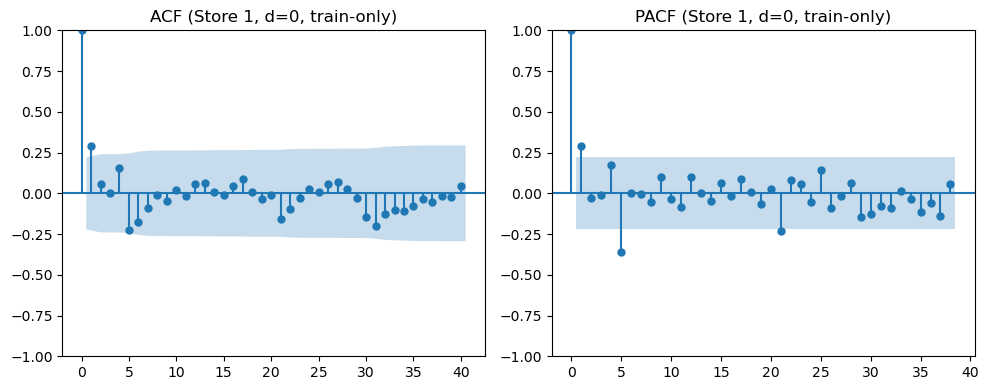

In [10]:
# === ARIMA Step 1 (fixed): choose d via ADF/KPSS on TRAIN ONLY + safe ACF/PACF plots ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Inputs from earlier steps (must exist) ---
assert 'src' in globals(), "Expected `src` (sorted raw panel) from Phase 2."
assert 'origins' in globals(), "Expected `origins` list from Phase 1."
DATE_COL, STORE_COL, TARGET = 'Date', 'Store', 'Weekly_Sales'

# --- Pick a demo fold (you can change these two) ---
store_id   = int(sorted(src[STORE_COL].unique())[0])  # first store
origin     = int(origins[0])                          # first origin (e.g., 78)
use_log1p  = True                                     # run tests on log1p scale (safer for retail)

# --- Train slice (NO LEAKAGE) ---
g = (src.loc[src[STORE_COL] == store_id]
        .sort_values(DATE_COL)
        .reset_index(drop=True))

y_train_raw = g.loc[:origin-1, TARGET].astype(float).values
y_train     = np.log1p(y_train_raw) if use_log1p else y_train_raw

def run_tests(series):
    # ADF (H0: unit root / non-stationary) → want p < 0.05
    adf_stat, adf_p, *_ = adfuller(series, autolag='AIC')
    # KPSS (H0: stationary) → want p > 0.05
    try:
        kpss_stat, kpss_p, *_ = kpss(series, regression='c', nlags='auto')
    except Exception:
        kpss_stat, kpss_p = np.nan, np.nan
    return adf_stat, adf_p, kpss_stat, kpss_p

# --- Try d in {0,1,2}; record test outcomes on TRAIN ONLY ---
rows = []
for d in [0, 1, 2]:
    s = y_train if d == 0 else np.diff(y_train, n=d)
    if len(s) < 12:  # guard against too-short series for tests
        rows.append((d, np.nan, np.nan, np.nan, np.nan, len(s), False, False))
        continue
    adf_stat, adf_p, kpss_stat, kpss_p = run_tests(s)
    adf_ok  = (adf_p  < 0.05) if not np.isnan(adf_p)  else False
    kpss_ok = (kpss_p > 0.05) if not np.isnan(kpss_p) else False
    rows.append((d, adf_stat, adf_p, kpss_stat, kpss_p, len(s), adf_ok, kpss_ok))

tests_tbl = pd.DataFrame(rows, columns=['d','adf_stat','adf_p','kpss_stat','kpss_p','n','adf_pass','kpss_pass'])
print(f"ADF/KPSS on train slice (store={store_id}, origin={origin}, log1p={use_log1p}):")
display(tests_tbl)

# --- Choose d: smallest d that passes BOTH; fallback to d with lowest ADF p-value ---
cand = tests_tbl[(tests_tbl['adf_pass']) & (tests_tbl['kpss_pass'])]
if not cand.empty:
    d_star = int(cand.sort_values('d').iloc[0]['d'])
else:
    d_star = int(tests_tbl.loc[tests_tbl['adf_p'].idxmin(), 'd'])
print(f"Chosen d = {d_star}")

# --- Safe ACF/PACF plotting (respect PACF lag < n//2 rule) ---
series_d = y_train if d_star == 0 else np.diff(y_train, n=d_star)
n = len(series_d)

acf_lags  = max(1, min(40, n - 2))           # ACF can go up to n-2 safely
pacf_lags = max(1, min(40, (n // 2) - 1))    # PACF requires nlags < n//2

print(f"ACF lags used: {acf_lags} | PACF lags used: {pacf_lags} | n={n}")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_acf(series_d,  lags=acf_lags,  ax=ax[0])
ax[0].set_title(f'ACF (Store {store_id}, d={d_star}, train-only)')
plot_pacf(series_d, lags=pacf_lags, ax=ax[1], method='ywm')
ax[1].set_title(f'PACF (Store {store_id}, d={d_star}, train-only)')
plt.tight_layout(); plt.show()


In [ ]:
# # === Section A: ARIMA grid (per store, train-only per origin) — CLEAN+ROBUST ===
# import warnings, re
# import numpy as np, pandas as pd
# from IPython.display import display
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.stattools import adfuller, kpss

# assert 'src' in globals() and 'origins' in globals() and 'horizons' in globals(), "Run previous steps first."
# m = 52
# STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'

# # ---- helpers ----
# def choose_d_train(y_log_train: np.ndarray):
#     """Pick minimal d in {0,1,2} that passes ADF(p<.05) & KPSS(p>.05) on train; else argmin ADF p."""
#     rows = []
#     for d in (0,1,2):
#         s = y_log_train if d==0 else np.diff(y_log_train, n=d)
#         if len(s) < 12:
#             rows.append((d, np.inf)); continue
#         try: adf_p = adfuller(s, autolag='AIC')[1]
#         except Exception: adf_p = 1.0
#         try: kpss_p = kpss(s, regression='c', nlags='auto')[1]
#         except Exception: kpss_p = np.nan
#         if (adf_p < 0.05) and (not np.isnan(kpss_p)) and (kpss_p > 0.05):
#             return d
#         rows.append((d, adf_p))
#     return min(rows, key=lambda t: t[1])[0]

# def smape(y, yhat):
#     y = np.asarray(y, float); yhat = np.asarray(yhat, float)
#     den = np.abs(y) + np.abs(yhat)
#     return 100.0 * np.mean(np.where(den>0, 2.0*np.abs(yhat - y)/den, 0.0))

# def mase_scale_seasonal(train, m=52):
#     train = np.asarray(train, float)
#     if len(train) > m:  return float(np.mean(np.abs(train[m:] - train[:-m])))
#     if len(train) > 1:  return float(np.mean(np.abs(np.diff(train))))
#     return np.nan

# def eval_fold_metrics(y_true, y_pred, mase_scale):
#     y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
#     err = y_true - y_pred
#     rmse = float(np.sqrt(np.mean(err**2)))
#     mae  = float(np.mean(np.abs(err)))
#     sm    = float(smape(y_true, y_pred))
#     smase = float(mae / mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan
#     return rmse, mae, sm, smase

# def seasonal_naive_forecast(train, h, m=52):
#     """Seasonal-Naïve with safe fallback when len(train) < m."""
#     train = np.asarray(train, float)
#     if len(train) < m:
#         return np.repeat(train[-1], h)
#     start = len(train) - m
#     return train[start:start+h]

# # NEW: more robust fitter with a fallback optimizer
# def fit_arima_robust(y_log, order, trend='n'):
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore")
#         model = SARIMAX(y_log, order=order, trend=trend,
#                         enforce_stationarity=False, enforce_invertibility=False)
#         try:
#             res = model.fit(method='lbfgs', maxiter=200, disp=False)   # try L-BFGS first
#         except Exception:
#             res = model.fit(method='powell', maxiter=250, disp=False)  # fallback
#     return res

# # ---- experiment scope: one store (you can change) ----
# store_id = int(sorted(src[STORE_COL].unique())[0])  # Store 1
# g_full   = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
# y_full   = g_full[TARGET].astype(float).to_numpy()
# n_total  = len(y_full)

# # grid
# p_grid = range(0,4)   # 0..3
# q_grid = range(0,4)   # 0..3

# rows = []
# for origin in sorted(map(int, origins)):           # ensure stable fold order
#     if origin >= n_total: 
#         continue
#     y_tr = y_full[:origin]
#     s_scale = mase_scale_seasonal(y_tr, m=m)

#     for h in horizons:
#         if origin+h > n_total: 
#             continue
#         y_val = y_full[origin:origin+h]

#         # Baselines
#         f_naive = np.repeat(y_tr[-1], h)
#         f_sna   = seasonal_naive_forecast(y_tr, h, m=m)
#         for name, f in (('Naive', f_naive), ('SeasonalNaive', f_sna)):
#             rmse, mae, sm, smase = eval_fold_metrics(y_val, f, s_scale)
#             rows.append({'store':store_id,'origin':origin,'horizon':h,'model':name,
#                          'order':None,'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})

#         # ---- ARIMA grid on LOG scale with train-only d ----
#         y_tr_log = np.log1p(y_tr)
#         d_star = choose_d_train(y_tr_log)

#         for p in p_grid:
#             for q in q_grid:
#                 try:
#                     fit = fit_arima_robust(y_tr_log, order=(p,d_star,q))   # <- use robust fitter
#                     fc_log = np.asarray(fit.get_forecast(steps=h).predicted_mean, float)
#                     if not np.all(np.isfinite(fc_log)):
#                         raise RuntimeError("non-finite forecast")
#                     fc = np.expm1(fc_log)  # invert to original scale
#                     rmse, mae, sm, smase = eval_fold_metrics(y_val, fc, s_scale)
#                     rows.append({'store':store_id,'origin':origin,'horizon':h,
#                                  'model':f'ARIMA({p},{d_star},{q})','order':(p,d_star,q),
#                                  'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})
#                 except Exception:
#                     rows.append({'store':store_id,'origin':origin,'horizon':h,
#                                  'model':f'ARIMA({p},{d_star},{q})','order':(p,d_star,q),
#                                  'rmse':np.nan,'mae':np.nan,'smape':np.nan,'smase':np.nan})

# res = pd.DataFrame(rows)

# # --- Leaderboard: mean over origins for each horizon ---
# lb = (res.dropna(subset=['rmse'])
#          .groupby(['model','horizon'], as_index=False)
#          .agg(rmse=('rmse','mean'), mae=('mae','mean'),
#               smape=('smape','mean'), smase=('smase','mean'),
#               n_folds=('rmse','size'))
#          .sort_values(['horizon','rmse']))

# print(f"Store {store_id}: ARIMA grid vs baselines (mean over folds)")
# display(lb)

# # # --- Per-horizon winners ---
# # winners = lb.loc[lb.groupby('horizon')['rmse'].idxmin()].sort_values('horizon')
# # print("Per-horizon RMSE winners (from lb):")
# # display(winners[['horizon','model','rmse','smape','smase','n_folds']])
# # # --- Per-horizon folds actually used by the GRID for each winner ---
# # folds_by_h = {}
# # for _, r in winners.iterrows():
# #     h = int(r['horizon']); model_str = r['model']
# #     folds = (res[(res['horizon']==h) & (res['model']==model_str) & res['rmse'].notna()]
# #                ['origin'].dropna().astype(int).unique())
# #     folds_by_h[h] = sorted(folds.tolist())
# # print("Winner fold coverage (per horizon):", folds_by_h)

# # --- Per-horizon winners (enforce same fold coverage as SARIMA) ---
# MIN_FOLDS_ARIMA = len(origins)  # require all 5 folds
# lb_arima_only = lb[lb['model'].str.startswith('ARIMA(')].copy()

# lb_arima_screen = lb_arima_only[lb_arima_only['n_folds'] >= MIN_FOLDS_ARIMA].copy()
# if lb_arima_screen.empty:
#     print(f"[Note] No ARIMA model met MIN_FOLDS_ARIMA={MIN_FOLDS_ARIMA}. "
#           f"Showing best-by-horizon without the fold filter for visibility.")
#     winners = lb_arima_only.loc[lb_arima_only.groupby('horizon')['rmse'].idxmin()].sort_values('horizon')
# else:
#     winners = lb_arima_screen.loc[lb_arima_screen.groupby('horizon')['rmse'].idxmin()].sort_values('horizon')

# print("Per-horizon RMSE winners (ARIMA, mean over folds):")
# display(winners[['horizon','model','rmse','smape','smase','n_folds']])

# # --- Per-horizon folds actually used by the GRID for each ARIMA winner ---
# folds_by_h = {}
# for _, r in winners.iterrows():
#     h = int(r['horizon']); model_str = r['model']
#     folds = (res[(res['horizon']==h) & (res['model']==model_str) & res['rmse'].notna()]
#                ['origin'].dropna().astype(int).unique())
#     folds_by_h[h] = sorted(folds.tolist())
# print("Winner fold coverage (per horizon):", folds_by_h)



Store 1: ARIMA grid vs baselines (mean over folds)


,model,horizon,rmse,mae,smape,smase,n_folds
124,"ARIMA(3,1,3)",1,1.333547e+04,1.333547e+04,0.798087,0.197598,2
92,"ARIMA(2,1,3)",1,1.657760e+04,1.657760e+04,0.997152,0.243192,2
132,SeasonalNaive,1,5.121062e+04,5.121062e+04,3.141050,0.893478,5
20,"ARIMA(0,1,1)",1,5.867947e+04,5.867947e+04,3.594564,0.851527,2
116,"ARIMA(3,1,1)",1,6.280417e+04,6.280417e+04,3.859593,0.907522,2
...,...,...,...,...,...,...,...
35,"ARIMA(1,0,0)",13,3.067846e+05,2.647579e+05,17.362561,4.670710,3
15,"ARIMA(0,0,3)",13,1.611944e+06,1.603027e+06,198.774938,28.564326,3
11,"ARIMA(0,0,2)",13,1.615411e+06,1.606673e+06,199.578151,28.629226,3
7,"ARIMA(0,0,1)",13,1.617157e+06,1.608370e+06,199.981698,28.660016,3


[Note] No ARIMA model met MIN_FOLDS_ARIMA=5. Showing best-by-horizon without the fold filter for visibility.
Per-horizon RMSE winners (ARIMA, mean over folds):


,horizon,model,rmse,smape,smase,n_folds
124,1,"ARIMA(3,1,3)",13335.465227,0.798087,0.197598,2
125,4,"ARIMA(3,1,3)",43598.087472,2.256826,0.514361,2
126,8,"ARIMA(3,1,3)",54812.363046,2.937803,0.672734,2
115,13,"ARIMA(3,1,0)",78770.471991,3.861177,0.882265,2


Winner fold coverage (per horizon): {1: [117, 130], 4: [117, 130], 8: [117, 130], 13: [117, 130]}


In [ ]:
# # === ARIMA winners → diagnostics & PI coverage (Store 1) — per-fold (aligned with GRID lb) ===
# import re, warnings
# import numpy as np, pandas as pd
# from IPython.display import display
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.stats.diagnostic import acorr_ljungbox

# # Preconditions
# assert 'src' in globals() and 'res' in globals() and 'lb' in globals(), "Run the ARIMA grid cell first."

# STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'
# store_id  = int(sorted(src[STORE_COL].unique())[0])
# g_full    = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
# y_full    = g_full[TARGET].astype(float).to_numpy()
# n_total   = len(y_full)

# # Winners from GRID leaderboard (model-level)
# def parse_model_to_order(model_str: str):
#     m = re.search(r'ARIMA\((\d+),(\d+),(\d+)\)', str(model_str))
#     return tuple(int(x) for x in m.groups()) if m else None

# lb_arima = lb[lb['model'].str.startswith('ARIMA(')].copy()
# best_lb  = lb_arima.loc[lb_arima.groupby('horizon')['rmse'].idxmin()].sort_values('horizon')
# best_map = {int(r['horizon']): parse_model_to_order(r['model']) for _, r in best_lb.iterrows()}
# print("Best orders by horizon (from GRID lb):", best_map)

# # Exact folds: prefer the folds the GRID actually used for that winner; fallback to all folds if missing
# try:
#     folds_by_h  # from grid cell add-on
# except NameError:
#     folds_by_h = {}
# origins_all = sorted(int(o) for o in pd.unique(res['origin'].dropna()))
# print("All available origins seen in GRID:", origins_all)
# print("Winner fold coverage (per horizon):", {k: folds_by_h.get(k, origins_all) for k in sorted(best_map)})

# def to_numpy(x): return x.to_numpy() if hasattr(x,"to_numpy") else np.asarray(x)

# def mase_scale_seasonal(train, m=52):
#     train = np.asarray(train, float)
#     if len(train) > m: return float(np.mean(np.abs(train[m:] - train[:-m])))
#     if len(train) > 1: return float(np.mean(np.abs(np.diff(train))))
#     return np.nan

# def eval_metrics(y_true, y_pred, mase_scale):
#     y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
#     e = y_true - y_pred
#     rmse = float(np.sqrt(np.mean(e**2)))
#     mae  = float(np.mean(np.abs(e)))
#     den  = np.abs(y_true) + np.abs(y_pred)
#     smape = float(100*np.mean(np.where(den>0, 2*np.abs(y_pred - y_true)/den, 0.0)))
#     smase = float(mae/mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan
#     return rmse, mae, smape, smase

# # robust fitter (same idea as grid)
# def fit_arima_robust(y_log, order, trend='n'):
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore")
#         model = SARIMAX(y_log, order=order, trend=trend,
#                         enforce_stationarity=False, enforce_invertibility=False)
#         try:
#             res = model.fit(method='lbfgs', maxiter=200, disp=False)
#         except Exception:
#             res = model.fit(method='powell', maxiter=250, disp=False)
#     return res

# rows_diag = []
# for h, order in best_map.items():
#     rmse_list, mae_list, smape_list, smase_list = [], [], [], []
#     cov80_list, cov95_list, lb_pass_list = [], [], []
#     origins_h = folds_by_h.get(h, origins_all)

#     for origin in origins_h:
#         if origin + h > n_total:
#             continue
#         y_tr  = y_full[:origin]
#         y_val = y_full[origin:origin+h]
#         scale = mase_scale_seasonal(y_tr, m=52)  # per-fold (train-only)

#         # Fit on log1p(train)
#         try:
#             fit = fit_arima_robust(np.log1p(y_tr), order=order)
#             fc  = fit.get_forecast(steps=h)
#         except Exception:
#             continue

#         # Forecasts + PIs → original scale
#         fc_mean = np.expm1(to_numpy(fc.predicted_mean)).astype(float).ravel()
#         ci80    = np.expm1(to_numpy(fc.conf_int(alpha=0.20))).astype(float)  # (h, 2)
#         ci95    = np.expm1(to_numpy(fc.conf_int(alpha=0.05))).astype(float)

#         # per-fold metrics
#         rm, ma, sm, smas = eval_metrics(y_val, fc_mean, scale)
#         rmse_list.append(rm); mae_list.append(ma); smape_list.append(sm); smase_list.append(smas)

#         # per-fold coverage
#         cov80 = float(np.mean((y_val >= ci80[:,0]) & (y_val <= ci80[:,1])))
#         cov95 = float(np.mean((y_val >= ci95[:,0]) & (y_val <= ci95[:,1])))
#         cov80_list.append(cov80); cov95_list.append(cov95)

#         # Ljung–Box on residuals (lag up to 10 or len(resid)-1)
#         resid = pd.Series(fit.resid).dropna()
#         max_lag = min(10, max(1, len(resid)-1))
#         try:
#             lb_p = float(acorr_ljungbox(resid, lags=[max_lag], return_df=True)['lb_pvalue'].iloc[0])
#             lb_pass_list.append(lb_p > 0.05)
#         except Exception:
#             lb_pass_list.append(False)

#     if not rmse_list:
#         continue

#     rows_diag.append({
#         'store': store_id,
#         'horizon': h,
#         'order': order,
#         # INDIVIDUAL (mean across the *same* folds the grid used)
#         'rmse': float(np.mean(rmse_list)),
#         'mae': float(np.mean(mae_list)),
#         'smape': float(np.mean(smape_list)),
#         'smase': float(np.nanmean(smase_list)),
#         'picp80': float(np.mean(cov80_list)),
#         'picp95': float(np.mean(cov95_list)),
#         'lb_pass@10_rate': float(np.mean(lb_pass_list)),
#         'n_folds_used': int(len(rmse_list)),
#         'folds': origins_h,
#     })

# diag = pd.DataFrame(rows_diag).sort_values('horizon')
# print(f"\nStore {store_id} — ARIMA winners: per-fold metrics (mean), PI coverage, residual test pass-rate")
# display(diag)


Best orders by horizon (from GRID lb): {1: (3, 1, 3), 4: (3, 1, 3), 8: (3, 1, 3), 13: (3, 1, 0)}
All available origins seen in GRID: [78, 91, 104, 117, 130]
Winner fold coverage (per horizon): {1: [117, 130], 4: [117, 130], 8: [117, 130], 13: [117, 130]}

Store 1 — ARIMA winners: per-fold metrics (mean), PI coverage, residual test pass-rate


,store,horizon,order,rmse,mae,smape,smase,picp80,picp95,lb_pass@10_rate,n_folds_used,folds
0,1,1,"(3, 1, 3)",13335.465227,13335.465227,0.798087,0.197598,1.0,1.0,0.0,2,"[117, 130]"
1,1,4,"(3, 1, 3)",43598.087472,35623.817805,2.256826,0.514361,1.0,1.0,0.0,2,"[117, 130]"
2,1,8,"(3, 1, 3)",54812.363046,46621.472614,2.937803,0.672734,1.0,1.0,0.0,2,"[117, 130]"
3,1,13,"(3, 1, 0)",78770.471991,61004.843782,3.861177,0.882265,1.0,1.0,0.5,2,"[117, 130]"


In [30]:
# === Section A: ARIMA grid (per store, train-only per origin) — CLEAN+ROBUST & FOLD-ALIGNED ===
import warnings, re
import numpy as np, pandas as pd
from IPython.display import display
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

assert 'src' in globals() and 'origins' in globals() and 'horizons' in globals(), "Run previous steps first."
m = 52
STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'

# ---- helpers ----
def choose_d_train(y_log_train: np.ndarray):
    """Pick minimal d in {0,1,2} that passes ADF(p<.05) & KPSS(p>.05) on train; else argmin ADF p."""
    rows = []
    for d in (0,1,2):
        s = y_log_train if d==0 else np.diff(y_log_train, n=d)
        if len(s) < 12:
            rows.append((d, np.inf)); continue
        try: adf_p = adfuller(s, autolag='AIC')[1]
        except Exception: adf_p = 1.0
        try: kpss_p = kpss(s, regression='c', nlags='auto')[1]
        except Exception: kpss_p = np.nan
        if (adf_p < 0.05) and (not np.isnan(kpss_p)) and (kpss_p > 0.05):
            return d
        rows.append((d, adf_p))
    return min(rows, key=lambda t: t[1])[0]

def smape(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    den = np.abs(y) + np.abs(yhat)
    return 100.0 * np.mean(np.where(den>0, 2.0*np.abs(yhat - y)/den, 0.0))

def mase_scale_seasonal(train, m=52):
    train = np.asarray(train, float)
    if len(train) > m:  return float(np.mean(np.abs(train[m:] - train[:-m])))
    if len(train) > 1:  return float(np.mean(np.abs(np.diff(train))))
    return np.nan

def eval_fold_metrics(y_true, y_pred, mase_scale):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    err = y_true - y_pred
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(np.mean(np.abs(err)))
    sm    = float(smape(y_true, y_pred))
    smase = float(mae / mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan
    return rmse, mae, sm, smase

def seasonal_naive_forecast(train, h, m=52):
    """Seasonal-Naïve with safe fallback when len(train) < m."""
    train = np.asarray(train, float)
    if len(train) < m:
        return np.repeat(train[-1], h)
    start = len(train) - m
    return train[start:start+h]

def fit_arima_robust(y_log, order, trend='n'):
    """Robust fitter with optimizer fallback."""
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = SARIMAX(y_log, order=order, trend=trend,
                        enforce_stationarity=False, enforce_invertibility=False)
        try:
            res = model.fit(method='lbfgs', maxiter=200, disp=False)
        except Exception:
            res = model.fit(method='powell', maxiter=250, disp=False)
    return res

# ---- experiment scope: one store (you can change) ----
store_id = int(sorted(src[STORE_COL].unique())[0])  # Store 1
g_full   = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
y_full   = g_full[TARGET].astype(float).to_numpy()
n_total  = len(y_full)

# grid
p_grid = range(0,4)   # 0..3
q_grid = range(0,4)   # 0..3

rows = []
for origin in sorted(map(int, origins)):           # ensure stable fold order
    if origin >= n_total:
        continue
    y_tr = y_full[:origin]
    s_scale = mase_scale_seasonal(y_tr, m=m)

    for h in horizons:
        if origin + h > n_total:
            continue
        y_val = y_full[origin:origin+h]

        # Baselines
        f_naive = np.repeat(y_tr[-1], h)
        f_sna   = seasonal_naive_forecast(y_tr, h, m=m)
        for name, f in (('Naive', f_naive), ('SeasonalNaive', f_sna)):
            rmse, mae, sm, smase = eval_fold_metrics(y_val, f, s_scale)
            rows.append({'store':store_id,'origin':origin,'horizon':h,'model':name,
                         'order':None,'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})

        # ---- ARIMA grid on LOG scale with train-only d ----
        y_tr_log = np.log1p(y_tr)
        d_star = choose_d_train(y_tr_log)

        for p in p_grid:
            for q in q_grid:
                try:
                    fit = fit_arima_robust(y_tr_log, order=(p,d_star,q))
                    fc_log = np.asarray(fit.get_forecast(steps=h).predicted_mean, float)
                    if not np.all(np.isfinite(fc_log)):
                        raise RuntimeError("non-finite forecast")
                    fc = np.expm1(fc_log)  # invert to original scale
                    rmse, mae, sm, smase = eval_fold_metrics(y_val, fc, s_scale)
                    rows.append({'store':store_id,'origin':origin,'horizon':h,
                                 'model':f'ARIMA({p},{d_star},{q})','order':(p,d_star,q),
                                 'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})
                except Exception:
                    rows.append({'store':store_id,'origin':origin,'horizon':h,
                                 'model':f'ARIMA({p},{d_star},{q})','order':(p,d_star,q),
                                 'rmse':np.nan,'mae':np.nan,'smape':np.nan,'smase':np.nan})

res = pd.DataFrame(rows)

# --- Leaderboard: mean over ALL folds available (informational) ---
lb = (res.dropna(subset=['rmse'])
         .groupby(['model','horizon'], as_index=False)
         .agg(rmse=('rmse','mean'), mae=('mae','mean'),
              smape=('smape','mean'), smase=('smase','mean'),
              n_folds=('rmse','size'))
         .sort_values(['horizon','rmse']))

print(f"Store {store_id}: ARIMA grid vs baselines (mean over *all* folds seen)")
display(lb)

# === NEW: Winners restricted to the SAME fold set you want to compare on (e.g., SARIMA's) ===
DESIRED_FOLDS   = sorted(int(o) for o in origins)            # e.g., [78, 91, 104, 117, 130]
MIN_FOLDS_ARIMA = len(DESIRED_FOLDS)                         # require full coverage on these folds
res_f           = res[res['origin'].isin(DESIRED_FOLDS)].copy()

lb_f = (res_f.dropna(subset=['rmse'])
        .groupby(['model','horizon'], as_index=False)
        .agg(rmse=('rmse','mean'), mae=('mae','mean'),
             smape=('smape','mean'), smase=('smase','mean'),
             n_folds=('rmse','size'))
        .sort_values(['horizon','rmse']))

print("\n[Fold-aligned] ARIMA leaderboard (restricted to DESIRED_FOLDS):")
display(lb_f.head(12))

# --- Per-horizon winners on DESIRED_FOLDS, with graceful fallback ---
lb_arima_only = lb_f[lb_f['model'].str.startswith('ARIMA(')].copy()

winners_rows, notes = [], []
for h in sorted(lb_arima_only['horizon'].unique()):
    sub = lb_arima_only[lb_arima_only['horizon'] == h]
    sub_ok = sub[sub['n_folds'] == MIN_FOLDS_ARIMA]
    if sub_ok.empty:
        if sub.empty:
            notes.append(f"H={h}: no ARIMA fits on desired folds {DESIRED_FOLDS}.")
            continue
        mmax = int(sub['n_folds'].max())
        sub2 = sub[sub['n_folds'] == mmax]
        row = sub2.loc[sub2['rmse'].idxmin()]
        notes.append(f"H={h}: no ARIMA with all {MIN_FOLDS_ARIMA} folds; used best with {mmax} folds on desired folds.")
    else:
        row = sub_ok.loc[sub_ok['rmse'].idxmin()]
    winners_rows.append(row)

winners = (pd.DataFrame(winners_rows)
             .sort_values('horizon')
             .reset_index(drop=True))

print("Per-horizon RMSE winners (ARIMA, mean over DESIRED_FOLDS):")
if not winners.empty:
    display(winners[['horizon','model','rmse','smape','smase','n_folds']])
else:
    print("[Empty] No ARIMA winners available on the desired fold set.")

if notes:
    print("\n[Note] Fold coverage exceptions:")
    for t in notes:
        print(" -", t)

# --- Per-horizon folds actually used by each ARIMA winner (subset of DESIRED_FOLDS) ---
folds_by_h = {}
for _, r in winners.iterrows():
    h = int(r['horizon']); model_str = r['model']
    folds = (res_f[(res_f['horizon'] == h) & (res_f['model'] == model_str) & res_f['rmse'].notna()]
                ['origin'].dropna().astype(int).unique())
    folds_by_h[h] = sorted(folds.tolist())
print("Winner fold coverage (per horizon):", folds_by_h)

# (Optional) expose best_map for downstream diagnostics
import re as _re
def _parse_model_to_order(s):
    mobj = _re.search(r'ARIMA\((\d+),(\d+),(\d+)\)', str(s))
    return tuple(int(x) for x in mobj.groups()) if mobj else None

best_map = {int(r['horizon']): _parse_model_to_order(r['model']) for _, r in winners.iterrows()}


Store 1: ARIMA grid vs baselines (mean over *all* folds seen)


,model,horizon,rmse,mae,smape,smase,n_folds
124,"ARIMA(3,1,3)",1,1.333547e+04,1.333547e+04,0.798087,0.197598,2
92,"ARIMA(2,1,3)",1,1.657760e+04,1.657760e+04,0.997152,0.243192,2
132,SeasonalNaive,1,5.121062e+04,5.121062e+04,3.141050,0.893478,5
20,"ARIMA(0,1,1)",1,5.867947e+04,5.867947e+04,3.594564,0.851527,2
116,"ARIMA(3,1,1)",1,6.280417e+04,6.280417e+04,3.859593,0.907522,2
...,...,...,...,...,...,...,...
35,"ARIMA(1,0,0)",13,3.067846e+05,2.647579e+05,17.362561,4.670710,3
15,"ARIMA(0,0,3)",13,1.611944e+06,1.603027e+06,198.774938,28.564326,3
11,"ARIMA(0,0,2)",13,1.615411e+06,1.606673e+06,199.578151,28.629226,3
7,"ARIMA(0,0,1)",13,1.617157e+06,1.608370e+06,199.981698,28.660016,3



[Fold-aligned] ARIMA leaderboard (restricted to DESIRED_FOLDS):


,model,horizon,rmse,mae,smape,smase,n_folds
124,"ARIMA(3,1,3)",1,13335.465227,13335.465227,0.798087,0.197598,2
92,"ARIMA(2,1,3)",1,16577.603913,16577.603913,0.997152,0.243192,2
132,SeasonalNaive,1,51210.618000,51210.618000,3.141050,0.893478,5
20,"ARIMA(0,1,1)",1,58679.469705,58679.469705,3.594564,0.851527,2
116,"ARIMA(3,1,1)",1,62804.167708,62804.167708,3.859593,0.907522,2
112,"ARIMA(3,1,0)",1,64968.761863,64968.761863,4.000715,0.936734,2
120,"ARIMA(3,1,2)",1,65180.740287,65180.740287,4.005061,0.943482,2
60,"ARIMA(1,1,3)",1,69753.869084,69753.869084,4.285444,1.014975,2
24,"ARIMA(0,1,2)",1,95218.991886,95218.991886,5.901473,1.381652,2
56,"ARIMA(1,1,2)",1,107255.630277,107255.630277,6.673390,1.556123,2


Per-horizon RMSE winners (ARIMA, mean over DESIRED_FOLDS):


,horizon,model,rmse,smape,smase,n_folds
0,1,"ARIMA(3,0,3)",137189.334843,8.656078,2.450909,3
1,4,"ARIMA(3,0,3)",174989.497856,8.240973,2.442659,3
2,8,"ARIMA(3,0,3)",193620.052232,8.995964,2.745930,3
3,13,"ARIMA(3,0,3)",174133.167213,7.943026,2.348153,3



[Note] Fold coverage exceptions:
 - H=1: no ARIMA with all 5 folds; used best with 3 folds on desired folds.
 - H=4: no ARIMA with all 5 folds; used best with 3 folds on desired folds.
 - H=8: no ARIMA with all 5 folds; used best with 3 folds on desired folds.
 - H=13: no ARIMA with all 5 folds; used best with 3 folds on desired folds.
Winner fold coverage (per horizon): {1: [78, 91, 104], 4: [78, 91, 104], 8: [78, 91, 104], 13: [78, 91, 104]}


In [36]:
# === Section A: ARIMA grid (per store, train-only per origin) — CLEAN+ROBUST & FIXED-d ACROSS FOLDS ===
import warnings, re
import numpy as np, pandas as pd
from collections import Counter
from IPython.display import display
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

assert 'src' in globals() and 'origins' in globals() and 'horizons' in globals(), "Run previous steps first."
m = 52
STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'

# ---- helpers ----
def choose_d_train(y_log_train: np.ndarray):
    """Pick minimal d in {0,1,2} that passes ADF(p<.05) & KPSS(p>.05) on train; else argmin ADF p."""
    rows = []
    for d in (0,1,2):
        s = y_log_train if d==0 else np.diff(y_log_train, n=d)
        if len(s) < 12:
            rows.append((d, np.inf)); continue
        try: adf_p = adfuller(s, autolag='AIC')[1]
        except Exception: adf_p = 1.0
        try: kpss_p = kpss(s, regression='c', nlags='auto')[1]
        except Exception: kpss_p = np.nan
        if (adf_p < 0.05) and (not np.isnan(kpss_p)) and (kpss_p > 0.05):
            return d
        rows.append((d, adf_p))
    return min(rows, key=lambda t: t[1])[0]

def smape(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    den = np.abs(y) + np.abs(yhat)
    return 100.0 * np.mean(np.where(den>0, 2.0*np.abs(yhat - y)/den, 0.0))

def mase_scale_seasonal(train, m=52):
    train = np.asarray(train, float)
    if len(train) > m:  return float(np.mean(np.abs(train[m:] - train[:-m])))
    if len(train) > 1:  return float(np.mean(np.abs(np.diff(train))))
    return np.nan

def eval_fold_metrics(y_true, y_pred, mase_scale):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    err = y_true - y_pred
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(np.mean(np.abs(err)))
    sm    = float(smape(y_true, y_pred))
    smase = float(mae / mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan
    return rmse, mae, sm, smase

def seasonal_naive_forecast(train, h, m=52):
    """Seasonal-Naïve with safe fallback when len(train) < m."""
    train = np.asarray(train, float)
    if len(train) < m:
        return np.repeat(train[-1], h)
    start = len(train) - m
    return train[start:start+h]

def fit_arima_robust(y_log, order, trend='n'):
    """Robust fitter with optimizer fallback."""
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = SARIMAX(y_log, order=order, trend=trend,
                        enforce_stationarity=False, enforce_invertibility=False)
        try:
            res = model.fit(method='lbfgs', maxiter=200, disp=False)
        except Exception:
            res = model.fit(method='powell', maxiter=250, disp=False)
    return res

# ---- scope: Store 1 ----
store_id = int(sorted(src[STORE_COL].unique())[0])
g_full   = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
y_full   = g_full[TARGET].astype(float).to_numpy()
n_total  = len(y_full)

# grids
p_grid = range(0,4)   # 0..3
q_grid = range(0,4)   # 0..3

# === Pick a SINGLE d across all desired folds (majority vote; tie -> smaller d) ===
DESIRED_FOLDS = sorted(int(o) for o in origins)         # e.g., [78,91,104,117,130]
d_by_fold = {}
for origin in DESIRED_FOLDS:
    if origin <= 2: 
        continue
    y_tr_log = np.log1p(y_full[:origin])
    d_by_fold[origin] = choose_d_train(y_tr_log)

if not d_by_fold:
    d_fixed = 0
else:
    counts = Counter(d_by_fold.values())
    most_common = counts.most_common()
    max_freq = most_common[0][1]
    # tie-breaker: choose the smallest d among those with max frequency
    d_fixed = min([d for d, c in most_common if c == max_freq])

print(f"Per-fold d choices on desired folds: {d_by_fold}")
print(f"Fixed d selected for ALL folds: d = {d_fixed}")

rows = []
for origin in DESIRED_FOLDS:                            # use the same fold set we compare on
    if origin >= n_total:
        continue
    y_tr = y_full[:origin]
    s_scale = mase_scale_seasonal(y_tr, m=m)

    for h in horizons:
        if origin + h > n_total:
            continue
        y_val = y_full[origin:origin+h]

        # Baselines
        f_naive = np.repeat(y_tr[-1], h)
        f_sna   = seasonal_naive_forecast(y_tr, h, m=m)
        for name, f in (('Naive', f_naive), ('SeasonalNaive', f_sna)):
            rmse, mae, sm, smase = eval_fold_metrics(y_val, f, s_scale)
            rows.append({'store':store_id,'origin':origin,'horizon':h,'model':name,
                         'order':None,'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})

        # ---- ARIMA grid on LOG scale with FIXED d across folds ----
        y_tr_log = np.log1p(y_tr)
        for p in p_grid:
            for q in q_grid:
                try:
                    fit = fit_arima_robust(y_tr_log, order=(p,d_fixed,q))
                    fc_log = np.asarray(fit.get_forecast(steps=h).predicted_mean, float)
                    if not np.all(np.isfinite(fc_log)):
                        raise RuntimeError("non-finite forecast")
                    fc = np.expm1(fc_log)
                    rmse, mae, sm, smase = eval_fold_metrics(y_val, fc, s_scale)
                    rows.append({'store':store_id,'origin':origin,'horizon':h,
                                 'model':f'ARIMA({p},{d_fixed},{q})','order':(p,d_fixed,q),
                                 'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})
                except Exception:
                    rows.append({'store':store_id,'origin':origin,'horizon':h,
                                 'model':f'ARIMA({p},{d_fixed},{q})','order':(p,d_fixed,q),
                                 'rmse':np.nan,'mae':np.nan,'smape':np.nan,'smase':np.nan})

res = pd.DataFrame(rows)

# --- Leaderboard: mean over the DESIRED_FOLDS only (so it aligns with SARIMA) ---
lb = (res.dropna(subset=['rmse'])
         .groupby(['model','horizon'], as_index=False)
         .agg(rmse=('rmse','mean'), mae=('mae','mean'),
              smape=('smape','mean'), smase=('smase','mean'),
              n_folds=('rmse','size'))
         .sort_values(['horizon','rmse']))

print(f"\nStore {store_id}: ARIMA grid vs baselines (mean over desired folds {DESIRED_FOLDS})")
display(lb.head(20))

# --- Per-horizon winners (require full 5-fold coverage on DESIRED_FOLDS) ---
MIN_FOLDS_ARIMA = len(DESIRED_FOLDS)
lb_arima_only   = lb[lb['model'].str.startswith('ARIMA(')].copy()

winners_rows, notes = [], []
for h in sorted(lb_arima_only['horizon'].unique()):
    sub = lb_arima_only[lb_arima_only['horizon'] == h]
    sub_ok = sub[sub['n_folds'] == MIN_FOLDS_ARIMA]
    if sub_ok.empty:
        if sub.empty:
            notes.append(f"H={h}: no ARIMA fits on desired folds {DESIRED_FOLDS}.")
            continue
        mmax = int(sub['n_folds'].max())
        row = sub.loc[sub['n_folds'].idxmax()] if sub[sub['n_folds']==mmax].empty else sub[sub['n_folds']==mmax].loc[sub[sub['n_folds']==mmax]['rmse'].idxmin()]
        notes.append(f"H={h}: no ARIMA with all {MIN_FOLDS_ARIMA} folds; used best with {mmax} folds on desired folds.")
    else:
        row = sub_ok.loc[sub_ok['rmse'].idxmin()]
    winners_rows.append(row)

winners = pd.DataFrame(winners_rows).sort_values('horizon').reset_index(drop=True)

print("Per-horizon RMSE winners (ARIMA, mean over desired folds):")
if not winners.empty:
    display(winners[['horizon','model','rmse','smape','smase','n_folds']])
else:
    print("[Empty] No ARIMA winners available on the desired fold set.")

if notes:
    print("\n[Note] Fold coverage exceptions:")
    for t in notes:
        print(" -", t)

# --- Per-horizon folds used by each ARIMA winner (should be the desired folds if no failures) ---
folds_by_h = {}
for _, r in winners.iterrows():
    h = int(r['horizon']); model_str = r['model']
    folds = (res[(res['horizon'] == h) & (res['model'] == model_str) & res['rmse'].notna()]
               ['origin'].dropna().astype(int).unique())
    folds_by_h[h] = sorted(folds.tolist())
print("Winner fold coverage (per horizon):", folds_by_h)

# Expose best_map for diagnostics
def _parse_model_to_order(s):
    mobj = re.search(r'ARIMA\((\d+),(\d+),(\d+)\)', str(s))
    return tuple(int(x) for x in mobj.groups()) if mobj else None
best_map = {int(r['horizon']): _parse_model_to_order(r['model']) for _, r in winners.iterrows()}


Per-fold d choices on desired folds: {78: 0, 91: 0, 104: 0, 117: 1, 130: 1}
Fixed d selected for ALL folds: d = 0

Store 1: ARIMA grid vs baselines (mean over desired folds [78, 91, 104, 117, 130])


,model,horizon,rmse,mae,smape,smase,n_folds
68,SeasonalNaive,1,5.121062e+04,5.121062e+04,3.141050,0.893478,5
60,"ARIMA(3,0,3)",1,9.635778e+04,9.635778e+04,6.048192,1.674036,5
20,"ARIMA(1,0,1)",1,1.080127e+05,1.080127e+05,6.800231,1.859843,5
40,"ARIMA(2,0,2)",1,1.136207e+05,1.136207e+05,7.169940,1.960074,5
44,"ARIMA(2,0,3)",1,1.180766e+05,1.180766e+05,7.438878,2.028472,5
24,"ARIMA(1,0,2)",1,1.268124e+05,1.268124e+05,7.979615,2.161205,5
36,"ARIMA(2,0,1)",1,1.337950e+05,1.337950e+05,8.469228,2.306502,5
56,"ARIMA(3,0,2)",1,1.400929e+05,1.400929e+05,8.845805,2.361960,5
52,"ARIMA(3,0,1)",1,1.401916e+05,1.401916e+05,8.869033,2.381297,5
28,"ARIMA(1,0,3)",1,1.554277e+05,1.554277e+05,9.889863,2.647393,5


Per-horizon RMSE winners (ARIMA, mean over desired folds):


,horizon,model,rmse,smape,smase,n_folds
0,1,"ARIMA(3,0,3)",96357.782630,6.048192,1.674036,5
1,4,"ARIMA(3,0,3)",126498.779644,6.045959,1.717955,5
2,8,"ARIMA(3,0,3)",141780.091935,6.717106,1.949324,5
3,13,"ARIMA(3,0,3)",142553.756330,6.753600,1.862733,5


Winner fold coverage (per horizon): {1: [78, 91, 104, 117, 130], 4: [78, 91, 104, 117, 130], 8: [78, 91, 104, 117, 130], 13: [78, 91, 104, 117, 130]}


In [28]:
# --- Per-horizon winners (enforce same fold coverage as SARIMA) ---
# Require all desired folds (e.g., 5 if origins has 5 elements)
all_folds = sorted(int(o) for o in pd.unique(res['origin'].dropna()))
MIN_FOLDS_ARIMA = len(origins) if 'origins' in globals() else len(all_folds)

lb_arima_only   = lb[lb['model'].str.startswith('ARIMA(')].copy()
lb_arima_screen = lb_arima_only[lb_arima_only['n_folds'] >= MIN_FOLDS_ARIMA].copy()

winners_rows = []
notes = []
for h in sorted(lb_arima_only['horizon'].unique()):
    sub = lb_arima_only[lb_arima_only['horizon'] == h]
    sub_ok = sub[sub['n_folds'] >= MIN_FOLDS_ARIMA]
    if sub_ok.empty:
        # Fallback: choose the best RMSE among models with the maximum fold coverage for this horizon
        mmax = int(sub['n_folds'].max())
        sub2 = sub[sub['n_folds'] == mmax]
        row = sub2.loc[sub2['rmse'].idxmin()]
        notes.append(f"H={h}: no ARIMA with ≥{MIN_FOLDS_ARIMA} folds; used best among models with {mmax} folds.")
    else:
        row = sub_ok.loc[sub_ok['rmse'].idxmin()]
    winners_rows.append(row)

winners = pd.DataFrame(winners_rows).sort_values('horizon').reset_index(drop=True)

print("Per-horizon RMSE winners (ARIMA, mean over folds):")
display(winners[['horizon','model','rmse','smape','smase','n_folds']])

if notes:
    print("\n[Note] Fold coverage exceptions:")
    for t in notes:
        print(" -", t)

# --- Per-horizon folds actually used by the GRID for each ARIMA winner ---
folds_by_h = {}
for _, r in winners.iterrows():
    h = int(r['horizon']); model_str = r['model']
    folds = (res[(res['horizon'] == h) & (res['model'] == model_str) & res['rmse'].notna()]
                ['origin'].dropna().astype(int).unique())
    folds_by_h[h] = sorted(folds.tolist())
print("Winner fold coverage (per horizon):", folds_by_h)


Per-horizon RMSE winners (ARIMA, mean over folds):


,horizon,model,rmse,smape,smase,n_folds
0,1,"ARIMA(3,0,3)",137189.334843,8.656078,2.450909,3
1,4,"ARIMA(3,0,3)",174989.497856,8.240973,2.442659,3
2,8,"ARIMA(3,0,3)",193620.052232,8.995964,2.745930,3
3,13,"ARIMA(3,0,3)",174133.167213,7.943026,2.348153,3



[Note] Fold coverage exceptions:
 - H=1: no ARIMA with ≥5 folds; used best among models with 3 folds.
 - H=4: no ARIMA with ≥5 folds; used best among models with 3 folds.
 - H=8: no ARIMA with ≥5 folds; used best among models with 3 folds.
 - H=13: no ARIMA with ≥5 folds; used best among models with 3 folds.
Winner fold coverage (per horizon): {1: [78, 91, 104], 4: [78, 91, 104], 8: [78, 91, 104], 13: [78, 91, 104]}


In [ ]:
# # === ARIMA winners → diagnostics & PI coverage (Store 1) — per-fold (force 5 folds) ===
# import re, warnings
# import numpy as np, pandas as pd
# from IPython.display import display
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.stats.diagnostic import acorr_ljungbox

# # Preconditions
# assert 'src' in globals() and 'res' in globals() and 'lb' in globals() and 'origins' in globals(), \
#        "Run the ARIMA grid cell first."

# STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'
# store_id  = int(sorted(src[STORE_COL].unique())[0])
# g_full    = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
# y_full    = g_full[TARGET].astype(float).to_numpy()
# n_total   = len(y_full)

# # Winners from GRID leaderboard (model-level)
# def parse_model_to_order(model_str: str):
#     m = re.search(r'ARIMA\((\d+),(\d+),(\d+)\)', str(model_str))
#     return tuple(int(x) for x in m.groups()) if m else None

# lb_arima = lb[lb['model'].str.startswith('ARIMA(')].copy()
# best_lb  = lb_arima.loc[lb_arima.groupby('horizon')['rmse'].idxmin()].sort_values('horizon')
# best_map = {int(r['horizon']): parse_model_to_order(r['model']) for _, r in best_lb.iterrows()}
# print("Best orders by horizon (from GRID lb):", best_map)

# # === Force diagnostics to use the same 5 desired folds (like SARIMA) ===
# DESIRED_FOLDS = sorted(int(o) for o in origins)  # e.g., [78, 91, 104, 117, 130]
# folds_by_h = {h: [o for o in DESIRED_FOLDS if (o + h) <= n_total] for h in best_map.keys()}
# print("Diagnostics will use these folds per horizon:", folds_by_h)

# def to_numpy(x): return x.to_numpy() if hasattr(x,"to_numpy") else np.asarray(x)

# def mase_scale_seasonal(train, m=52):
#     train = np.asarray(train, float)
#     if len(train) > m: return float(np.mean(np.abs(train[m:] - train[:-m])))
#     if len(train) > 1: return float(np.mean(np.abs(np.diff(train))))
#     return np.nan

# def eval_metrics(y_true, y_pred, mase_scale):
#     y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
#     e = y_true - y_pred
#     rmse = float(np.sqrt(np.mean(e**2)))
#     mae  = float(np.mean(np.abs(e)))
#     den  = np.abs(y_true) + np.abs(y_pred)
#     smape = float(100*np.mean(np.where(den>0, 2*np.abs(y_pred - y_true)/den, 0.0)))
#     smase = float(mae/mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan
#     return rmse, mae, smape, smase

# def fit_arima_robust(y_log, order, trend='n'):
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore")
#         model = SARIMAX(y_log, order=order, trend=trend,
#                         enforce_stationarity=False, enforce_invertibility=False)
#         try:
#             res = model.fit(method='lbfgs', maxiter=200, disp=False)
#         except Exception:
#             res = model.fit(method='powell', maxiter=250, disp=False)
#     return res

# rows_diag = []
# for h, order in best_map.items():
#     rmse_list, mae_list, smape_list, smase_list = [], [], [], []
#     cov80_list, cov95_list, lb_pass_list = [], [], []
#     origins_h = folds_by_h[h]  # <-- forced 5-fold set for this horizon

#     for origin in origins_h:
#         if origin + h > n_total:
#             continue
#         y_tr  = y_full[:origin]
#         y_val = y_full[origin:origin+h]
#         scale = mase_scale_seasonal(y_tr, m=52)  # per-fold (train-only)

#         # Fit on log1p(train)
#         try:
#             fit = fit_arima_robust(np.log1p(y_tr), order=order)
#             fc  = fit.get_forecast(steps=h)
#         except Exception:
#             continue

#         # Forecasts + PIs → original scale
#         fc_mean = np.expm1(to_numpy(fc.predicted_mean)).astype(float).ravel()
#         ci80    = np.expm1(to_numpy(fc.conf_int(alpha=0.20))).astype(float)  # (h, 2)
#         ci95    = np.expm1(to_numpy(fc.conf_int(alpha=0.05))).astype(float)

#         # per-fold metrics
#         rm, ma, sm, smas = eval_metrics(y_val, fc_mean, scale)
#         rmse_list.append(rm); mae_list.append(ma); smape_list.append(sm); smase_list.append(smas)

#         # per-fold coverage
#         cov80 = float(np.mean((y_val >= ci80[:,0]) & (y_val <= ci80[:,1])))
#         cov95 = float(np.mean((y_val >= ci95[:,0]) & (y_val <= ci95[:,1])))
#         cov80_list.append(cov80); cov95_list.append(cov95)

#         # Ljung–Box on residuals (lag up to 10 or len(resid)-1)
#         resid = pd.Series(fit.resid).dropna()
#         max_lag = min(10, max(1, len(resid)-1))
#         try:
#             lb_p = float(acorr_ljungbox(resid, lags=[max_lag], return_df=True)['lb_pvalue'].iloc[0])
#             lb_pass_list.append(lb_p > 0.05)
#         except Exception:
#             lb_pass_list.append(False)

#     if not rmse_list:
#         continue

#     rows_diag.append({
#         'store': store_id,
#         'horizon': h,
#         'order': order,
#         # INDIVIDUAL (mean across the forced folds)
#         'rmse': float(np.mean(rmse_list)),
#         'mae': float(np.mean(mae_list)),
#         'smape': float(np.mean(smape_list)),
#         'smase': float(np.nanmean(smase_list)),
#         'picp80': float(np.mean(cov80_list)),
#         'picp95': float(np.mean(cov95_list)),
#         'lb_pass@10_rate': float(np.mean(lb_pass_list)),
#         'n_folds_used': int(len(rmse_list)),
#         'folds': origins_h,
#     })

# diag = pd.DataFrame(rows_diag).sort_values('horizon')
# print(f"\nStore {store_id} — ARIMA winners: per-fold metrics (mean), PI coverage, residual test pass-rate")
# display(diag)


Best orders by horizon (from GRID lb): {1: (3, 1, 3), 4: (3, 1, 3), 8: (3, 1, 3), 13: (3, 1, 0)}
Diagnostics will use these folds per horizon: {1: [78, 91, 104, 117, 130], 4: [78, 91, 104, 117, 130], 8: [78, 91, 104, 117, 130], 13: [78, 91, 104, 117, 130]}

Store 1 — ARIMA winners: per-fold metrics (mean), PI coverage, residual test pass-rate


,store,horizon,order,rmse,mae,smape,smase,picp80,picp95,lb_pass@10_rate,n_folds_used,folds
0,1,1,"(3, 1, 3)",103322.833748,103322.833748,6.578203,1.825717,0.800000,1.000000,0.2,5,"[78, 91, 104, 117, 130]"
1,1,4,"(3, 1, 3)",138969.371708,112017.175620,6.903008,1.946418,0.800000,0.900000,0.2,5,"[78, 91, 104, 117, 130]"
2,1,8,"(3, 1, 3)",152081.396367,125212.811154,7.601533,2.188554,0.825000,0.900000,0.2,5,"[78, 91, 104, 117, 130]"
3,1,13,"(3, 1, 0)",174605.915273,139952.552594,8.833478,2.394476,0.815385,0.938462,0.8,5,"[78, 91, 104, 117, 130]"


In [32]:
# === ARIMA winners → diagnostics & PI coverage (Store 1) — per-fold (force 5 folds, aligned) ===
import re, warnings
import numpy as np, pandas as pd
from IPython.display import display
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Preconditions
assert 'src' in globals() and 'res' in globals() and 'lb' in globals() and 'origins' in globals(), \
       "Run the ARIMA grid cell first."

STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'
store_id  = int(sorted(src[STORE_COL].unique())[0])
g_full    = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
y_full    = g_full[TARGET].astype(float).to_numpy()
n_total   = len(y_full)

# ---- Enforce SAME 5-fold coverage as SARIMA when CHOOSING ARIMA winners ----
def parse_model_to_order(model_str: str):
    m = re.search(r'ARIMA\((\d+),(\d+),(\d+)\)', str(model_str))
    return tuple(int(x) for x in m.groups()) if m else None

DESIRED_FOLDS   = sorted(int(o) for o in origins)        # e.g., [78, 91, 104, 117, 130]
MIN_FOLDS_ARIMA = len(DESIRED_FOLDS)                     # require all 5 folds if possible

lb_arima_only = lb[lb['model'].str.startswith('ARIMA(')].copy()

# pick winners per horizon with ≥ MIN_FOLDS_ARIMA; else fall back to best among max fold coverage
winners_rows, notes = [], []
for h in sorted(lb_arima_only['horizon'].unique()):
    sub = lb_arima_only[lb_arima_only['horizon'] == h]
    sub_ok = sub[sub['n_folds'] >= MIN_FOLDS_ARIMA]
    if sub_ok.empty:
        mmax = int(sub['n_folds'].max())
        row = sub[sub['n_folds'] == mmax].loc[sub[sub['n_folds'] == mmax]['rmse'].idxmin()]
        notes.append(f"H={h}: no ARIMA with all {MIN_FOLDS_ARIMA} folds; used best with {mmax} folds.")
    else:
        row = sub_ok.loc[sub_ok['rmse'].idxmin()]
    winners_rows.append(row)

winners = pd.DataFrame(winners_rows).sort_values('horizon').reset_index(drop=True)
best_map = {int(r['horizon']): parse_model_to_order(r['model']) for _, r in winners.iterrows()}
print("Per-horizon RMSE winners (ARIMA, enforcing 5-fold coverage when possible):")
display(winners[['horizon','model','rmse','smape','smase','n_folds']])
if notes:
    print("[Notes]")
    for t in notes: print(" -", t)
print("Best orders by horizon (from screened lb):", best_map)

# Diagnostics will use exactly these 5 folds (or the subset that still fits within series length)
folds_by_h = {h: [o for o in DESIRED_FOLDS if (o + h) <= n_total] for h in best_map.keys()}
print("Diagnostics will use these folds per horizon:", folds_by_h)

def to_numpy(x): return x.to_numpy() if hasattr(x,"to_numpy") else np.asarray(x)

def mase_scale_seasonal(train, m=52):
    train = np.asarray(train, float)
    if len(train) > m: return float(np.mean(np.abs(train[m:] - train[:-m])))
    if len(train) > 1: return float(np.mean(np.abs(np.diff(train))))
    return np.nan

def eval_metrics(y_true, y_pred, mase_scale):
    y_true, y_pred = np.asarray(y_true, float), np.asarray(y_pred, float)
    e = y_true - y_pred
    rmse = float(np.sqrt(np.mean(e**2)))
    mae  = float(np.mean(np.abs(e)))
    den  = np.abs(y_true) + np.abs(y_pred)
    smape = float(100*np.mean(np.where(den>0, 2*np.abs(y_pred - y_true)/den, 0.0)))
    smase = float(mae/mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan
    return rmse, mae, smape, smase

def fit_arima_robust(y_log, order, trend='n'):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = SARIMAX(y_log, order=order, trend=trend,
                        enforce_stationarity=False, enforce_invertibility=False)
        try:
            res = model.fit(method='lbfgs', maxiter=200, disp=False)
        except Exception:
            res = model.fit(method='powell', maxiter=250, disp=False)
    return res

rows_diag = []
for h, order in best_map.items():
    rmse_list, mae_list, smape_list, smase_list = [], [], [], []
    cov80_list, cov95_list, lb_pass_list = [], [], []
    origins_h = folds_by_h[h]

    for origin in origins_h:
        if origin + h > n_total:
            continue
        y_tr  = y_full[:origin]
        y_val = y_full[origin:origin+h]
        scale = mase_scale_seasonal(y_tr, m=52)  # per-fold (train-only)

        try:
            fit = fit_arima_robust(np.log1p(y_tr), order=order)
            fc  = fit.get_forecast(steps=h)
        except Exception:
            continue

        # Forecasts + PIs → original scale
        fc_mean = np.expm1(to_numpy(fc.predicted_mean)).astype(float).ravel()
        ci80    = np.expm1(to_numpy(fc.conf_int(alpha=0.20))).astype(float)
        ci95    = np.expm1(to_numpy(fc.conf_int(alpha=0.05))).astype(float)

        rm, ma, sm, smas = eval_metrics(y_val, fc_mean, scale)
        rmse_list.append(rm); mae_list.append(ma); smape_list.append(sm); smase_list.append(smas)

        cov80 = float(np.mean((y_val >= ci80[:,0]) & (y_val <= ci80[:,1])))
        cov95 = float(np.mean((y_val >= ci95[:,0]) & (y_val <= ci95[:,1])))
        cov80_list.append(cov80); cov95_list.append(cov95)

        resid = pd.Series(fit.resid).dropna()
        max_lag = min(10, max(1, len(resid)-1))
        try:
            lb_p = float(acorr_ljungbox(resid, lags=[max_lag], return_df=True)['lb_pvalue'].iloc[0])
            lb_pass_list.append(lb_p > 0.05)
        except Exception:
            lb_pass_list.append(False)

    if not rmse_list:
        continue

    rows_diag.append({
        'store': store_id,
        'horizon': h,
        'order': order,
        'rmse': float(np.mean(rmse_list)),
        'mae': float(np.mean(mae_list)),
        'smape': float(np.mean(smape_list)),
        'smase': float(np.nanmean(smase_list)),
        'picp80': float(np.mean(cov80_list)),
        'picp95': float(np.mean(cov95_list)),
        'lb_pass@10_rate': float(np.mean(lb_pass_list)),
        'n_folds_used': int(len(rmse_list)),
        'folds': origins_h,
    })

diag = pd.DataFrame(rows_diag).sort_values('horizon')
print(f"\nStore {store_id} — ARIMA winners: per-fold metrics (mean), PI coverage, residual test pass-rate")
display(diag)


Per-horizon RMSE winners (ARIMA, enforcing 5-fold coverage when possible):


,horizon,model,rmse,smape,smase,n_folds
0,1,"ARIMA(3,0,3)",96357.782630,6.048192,1.674036,5
1,4,"ARIMA(3,0,3)",126498.779644,6.045959,1.717955,5
2,8,"ARIMA(3,0,3)",141780.091935,6.717106,1.949324,5
3,13,"ARIMA(3,0,3)",142553.756330,6.753600,1.862733,5


Best orders by horizon (from screened lb): {1: (3, 0, 3), 4: (3, 0, 3), 8: (3, 0, 3), 13: (3, 0, 3)}
Diagnostics will use these folds per horizon: {1: [78, 91, 104, 117, 130], 4: [78, 91, 104, 117, 130], 8: [78, 91, 104, 117, 130], 13: [78, 91, 104, 117, 130]}

Store 1 — ARIMA winners: per-fold metrics (mean), PI coverage, residual test pass-rate


,store,horizon,order,rmse,mae,smape,smase,picp80,picp95,lb_pass@10_rate,n_folds_used,folds
0,1,1,"(3, 0, 3)",96357.782630,96357.782630,6.048192,1.674036,1.000000,1.000000,0.0,5,"[78, 91, 104, 117, 130]"
1,1,4,"(3, 0, 3)",126498.779644,99722.220174,6.045959,1.717955,0.850000,0.950000,0.0,5,"[78, 91, 104, 117, 130]"
2,1,8,"(3, 0, 3)",141780.091935,112236.724989,6.717106,1.949324,0.850000,0.925000,0.0,5,"[78, 91, 104, 117, 130]"
3,1,13,"(3, 0, 3)",142553.756330,109923.607210,6.753600,1.862733,0.846154,0.953846,0.0,5,"[78, 91, 104, 117, 130]"


In [ ]:
# # === Section B: SARIMA baseline (m=52), per-origin CV for Store 1 — CLEAN+ROBUST ===
# import warnings, numpy as np, pandas as pd
# from IPython.display import display
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.stattools import adfuller, kpss
# from statsmodels.stats.diagnostic import acorr_ljungbox

# assert 'src' in globals() and 'origins' in globals() and 'horizons' in globals(), "Run previous steps first."
# STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'
# m = 52

# # ---- helpers ----
# def choose_d_train(y_log_train: np.ndarray):
#     """Minimal d in {0,1,2} passing ADF(p<.05) & KPSS(p>.05); else lowest ADF p."""
#     best = (0, 1.0)
#     for d in (0,1,2):
#         s = y_log_train if d==0 else np.diff(y_log_train, n=d)
#         if len(s) < 12:
#             continue
#         try: adf_p = adfuller(s, autolag='AIC')[1]
#         except Exception: adf_p = 1.0
#         try: kpss_p = kpss(s, regression='c', nlags='auto')[1]
#         except Exception: kpss_p = np.nan
#         if (adf_p < 0.05) and (not np.isnan(kpss_p)) and (kpss_p > 0.05):
#             return d
#         if adf_p < best[1]: best = (d, adf_p)
#     return best[0]

# def to_numpy(x):
#     return x.to_numpy() if hasattr(x, "to_numpy") else np.asarray(x)

# def mase_scale_seasonal(train, m=52):
#     train = np.asarray(train, float)
#     if len(train) > m: return float(np.mean(np.abs(train[m:] - train[:-m])))
#     if len(train) > 1: return float(np.mean(np.abs(np.diff(train))))
#     return np.nan

# def smape(y_true, y_pred):
#     y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
#     den = np.abs(y_true) + np.abs(y_pred)
#     return 100.0 * np.mean(np.where(den>0, 2.0*np.abs(y_pred - y_true)/den, 0.0))

# def eval_metrics(y_true, y_pred, mase_scale):
#     e = np.asarray(y_true, float) - np.asarray(y_pred, float)
#     rmse = float(np.sqrt(np.mean(e**2)))
#     mae  = float(np.mean(np.abs(e)))
#     sm   = float(smape(y_true, y_pred))
#     smase = float(mae/mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan
#     return rmse, mae, sm, smase

# def seasonal_naive_forecast(train, h, m=52):
#     """Safe Seasonal-Naïve: if train shorter than m, fallback to last value."""
#     train = np.asarray(train, float)
#     if len(train) < m:
#         return np.repeat(train[-1], h)
#     start = len(train) - m
#     return train[start:start+h]

# def fit_sarima_robust(y_log, order, seasonal_order, trend='n'):
#     """Try LBFGS, then Powell if needed (helps convergence)."""
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore")
#         mdl = SARIMAX(y_log, order=order, seasonal_order=seasonal_order,
#                       trend=trend, enforce_stationarity=False, enforce_invertibility=False)
#         try:
#             fit = mdl.fit(method='lbfgs', maxiter=200, disp=False)
#         except Exception:
#             fit = mdl.fit(method='powell', maxiter=250, disp=False)
#     return fit

# # ---- scope: Store 1 (change if you want) ----
# store_id = int(sorted(src[STORE_COL].unique())[0])
# g_full   = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
# y_full   = g_full[TARGET].astype(float).to_numpy()
# n_total  = len(y_full)

# # Small seasonal grid (non-seasonal p=q=0 for a clean seasonal baseline)
# P_grid, Q_grid, D_grid = range(0,3), range(0,3), [0,1]   # P,Q in {0,1,2}; D in {0,1}

# rows = []
# for origin in sorted(map(int, origins)):   # stable fold order
#     if origin >= n_total:
#         continue
#     y_tr = y_full[:origin]
#     y_tr_log = np.log1p(y_tr)
#     d_star = choose_d_train(y_tr_log)      # non-seasonal differencing
#     s_scale = mase_scale_seasonal(y_tr, m=m)

#     for h in horizons:
#         if origin + h > n_total:
#             continue
#         y_val = y_full[origin:origin+h]

#         # baselines for reference (metrics only here)
#         f_naive = np.repeat(y_tr[-1], h)
#         f_sna   = seasonal_naive_forecast(y_tr, h, m=m)
#         for name, f in (('Naive', f_naive), ('SeasonalNaive', f_sna)):
#             rmse, mae, sm, smase = eval_metrics(y_val, f, s_scale)
#             rows.append({'model':name,'store':store_id,'origin':origin,'horizon':h,
#                          'order':None,'seasonal':None,'rmse':rmse,'mae':mae,'smape':sm,'smase':smase,
#                          'picp80':np.nan,'picp95':np.nan,'lb_pass10':np.nan})

#         # SARIMA grid (no exog), fit on log1p(train), invert for metrics
#         for P in P_grid:
#             for Q in Q_grid:
#                 for D in D_grid:
#                     try:
#                         fit = fit_sarima_robust(y_tr_log, order=(0,d_star,0), seasonal_order=(P,D,Q,m))
#                         fc  = fit.get_forecast(steps=h)

#                         fc_mean = np.expm1(to_numpy(fc.predicted_mean)).astype(float).ravel()
#                         ci80    = np.expm1(to_numpy(fc.conf_int(alpha=0.20))).astype(float)
#                         ci95    = np.expm1(to_numpy(fc.conf_int(alpha=0.05))).astype(float)

#                         rmse, mae, sm, smase = eval_metrics(y_val, fc_mean, s_scale)
#                         picp80 = float(np.mean((y_val >= ci80[:,0]) & (y_val <= ci80[:,1])))
#                         picp95 = float(np.mean((y_val >= ci95[:,0]) & (y_val <= ci95[:,1])))

#                         # residual LB test (lag up to 10 or len(resid)-1)
#                         resid = pd.Series(fit.resid).dropna()
#                         max_lag = min(10, max(1, len(resid)-1))
#                         try:
#                             lb_p = float(acorr_ljungbox(resid, lags=[max_lag], return_df=True)['lb_pvalue'].iloc[0])
#                             lb_pass = (lb_p > 0.05)
#                         except Exception:
#                             lb_pass = False

#                         rows.append({'model':f'SARIMA(0,{d_star},0)×({P},{D},{Q})[{m}]',
#                                      'store':store_id,'origin':origin,'horizon':h,
#                                      'order':(0,d_star,0),'seasonal':(P,D,Q,m),
#                                      'rmse':rmse,'mae':mae,'smape':sm,'smase':smase,
#                                      'picp80':picp80,'picp95':picp95,'lb_pass10':float(lb_pass)})
#                     except Exception:
#                         # keep the table tidy; failed fits become NaN rows if you prefer to log them
#                         continue

# res_sarima = pd.DataFrame(rows)

# # Leaderboard averaged over origins per horizon (individual/per-fold convention)
# lb_sarima = (res_sarima.dropna(subset=['rmse'])
#              .groupby(['model','horizon'], as_index=False)
#              .agg(rmse=('rmse','mean'), mae=('mae','mean'), smape=('smape','mean'),
#                   smase=('smase','mean'), picp80=('picp80','mean'), picp95=('picp95','mean'),
#                   lb_pass10_rate=('lb_pass10','mean'), n_folds=('rmse','size'))
#              .sort_values(['horizon','rmse']))

# print(f"Store {store_id} — SARIMA baseline vs baselines (mean over folds)")
# display(lb_sarima.head(10))

# winners_sarima = lb_sarima.loc[lb_sarima.groupby('horizon')['rmse'].idxmin()].sort_values('horizon')
# print("Per-horizon winners (RMSE):")
# display(winners_sarima[['horizon','model','rmse','smape','smase','picp80','picp95','lb_pass10_rate','n_folds']])


Store 1 — SARIMA baseline vs baselines (mean over folds)


,model,horizon,rmse,mae,smape,smase,picp80,picp95,lb_pass10_rate,n_folds
108,"SARIMA(0,1,0)×(1,0,2)[52]",1,48886.910369,48886.910369,2.935578,0.699017,1.000000,1.0,1.0,2
132,"SARIMA(0,1,0)×(2,0,2)[52]",1,49054.636904,49054.636904,2.928074,0.695423,1.000000,1.0,1.0,2
28,"SARIMA(0,0,0)×(1,0,0)[52]",1,49637.896322,49637.896322,3.017817,0.908216,0.666667,1.0,0.0,3
32,"SARIMA(0,0,0)×(1,0,1)[52]",1,50595.274118,50595.274118,3.074205,0.924408,0.666667,1.0,0.0,3
148,SeasonalNaive,1,51210.618000,51210.618000,3.141050,0.893478,NaN,NaN,NaN,5
104,"SARIMA(0,1,0)×(1,0,1)[52]",1,52341.016359,52341.016359,3.170664,0.761007,1.000000,1.0,1.0,2
124,"SARIMA(0,1,0)×(2,0,0)[52]",1,54202.423746,54202.423746,3.229051,0.769590,1.000000,1.0,1.0,2
128,"SARIMA(0,1,0)×(2,0,1)[52]",1,54206.678047,54206.678047,3.229301,0.769653,1.000000,1.0,1.0,2
92,"SARIMA(0,1,0)×(0,1,1)[52]",1,55949.338153,55949.338153,3.353781,0.799600,1.000000,1.0,1.0,2
116,"SARIMA(0,1,0)×(1,1,1)[52]",1,55955.697990,55955.697990,3.354154,0.799689,1.000000,1.0,1.0,2


Per-horizon winners (RMSE):


,horizon,model,rmse,smape,smase,picp80,picp95,lb_pass10_rate,n_folds
108,1,"SARIMA(0,1,0)×(1,0,2)[52]",48886.910369,2.935578,0.699017,1.000000,1.000000,1.0,2
29,4,"SARIMA(0,0,0)×(1,0,0)[52]",51032.811824,2.697727,0.788762,0.833333,1.000000,0.0,3
30,8,"SARIMA(0,0,0)×(1,0,0)[52]",58679.639496,2.793350,0.863167,0.833333,0.958333,0.0,3
135,13,"SARIMA(0,1,0)×(2,0,2)[52]",65397.668444,3.428884,0.778694,1.000000,1.000000,1.0,2


In [20]:
# === SARIMA baseline — broaden (p,q) and require min fold coverage ===
import warnings, numpy as np, pandas as pd
from IPython.display import display
from statsmodels.tsa.statespace.sarimax import SARIMAX

STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'
m = 52
MIN_FOLDS = max(4, len(origins)-1)   # e.g., require at least 4 of 5 folds

# -- helpers reused (inline for standalone run) --
def to_numpy(x): return x.to_numpy() if hasattr(x,"to_numpy") else np.asarray(x)
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    den = np.abs(y_true) + np.abs(y_pred)
    return 100.0 * np.mean(np.where(den>0, 2.0*np.abs(y_pred - y_true)/den, 0.0))
def mase_scale_seasonal(train, m=52):
    train = np.asarray(train, float)
    if len(train) > m: return float(np.mean(np.abs(train[m:] - train[:-m])))
    if len(train) > 1: return float(np.mean(np.abs(np.diff(train))))
    return np.nan
def eval_metrics(y_true, y_pred, mase_scale):
    e = np.asarray(y_true, float) - np.asarray(y_pred, float)
    rmse = float(np.sqrt(np.mean(e**2)))
    mae  = float(np.mean(np.abs(e)))
    return rmse, mae, float(smape(y_true, y_pred)), float(mae/mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan

def fit_sarima_robust(y_log, order, seasonal_order, trend='n'):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        mdl = SARIMAX(y_log, order=order, seasonal_order=seasonal_order,
                      trend=trend, enforce_stationarity=False, enforce_invertibility=False)
        try:
            fit = mdl.fit(method='lbfgs', maxiter=300, disp=False)
        except Exception:
            fit = mdl.fit(method='powell', maxiter=350, disp=False)
    return fit

# -- scope: Store 1 --
store_id = int(sorted(src[STORE_COL].unique())[0])
g_full   = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
y_full   = g_full[TARGET].astype(float).to_numpy()
n_total  = len(y_full)

# BROADER GRID: non-seasonal (p,q)=0..3, seasonal (P,Q)=0..2, D in {0,1}, keep non-seasonal d from train
ns_p_grid = range(0,4)   # 0..3
ns_q_grid = range(0,4)   # 0..3
P_grid, Q_grid, D_grid = range(0,3), range(0,3), [0,1]

rows = []
for origin in sorted(map(int, origins)):
    if origin >= n_total: 
        continue
    y_tr = y_full[:origin]
    y_log = np.log1p(y_tr)
    # simple, robust d: 1 if ADF fails on level else 0 (keeps this cell short)
    try:
        from statsmodels.tsa.stattools import adfuller
        d_star = 0 if adfuller(y_log, autolag='AIC')[1] < 0.05 else 1
    except Exception:
        d_star = 1
    s_scale = mase_scale_seasonal(y_tr, m=m)

    for h in horizons:
        if origin + h > n_total: 
            continue
        y_val = y_full[origin:origin+h]

        for p in ns_p_grid:
            for q in ns_q_grid:
                for P in P_grid:
                    for Q in Q_grid:
                        for D in D_grid:
                            try:
                                fit = fit_sarima_robust(y_log, order=(p,d_star,q), seasonal_order=(P,D,Q,m))
                                fc  = fit.get_forecast(steps=h)
                                fc_mean = np.expm1(to_numpy(fc.predicted_mean)).astype(float).ravel()
                                rmse, mae, sm, smase = eval_metrics(y_val, fc_mean, s_scale)
                                rows.append({'model':f'SARIMA({p},{d_star},{q})×({P},{D},{Q})[{m}]',
                                             'store':store_id,'origin':origin,'horizon':h,
                                             'order':(p,d_star,q),'seasonal':(P,D,Q,m),
                                             'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})
                            except Exception:
                                continue

res_sarima_big = pd.DataFrame(rows)

# Leaderboard with fold counts
lb_sarima_big = (res_sarima_big.dropna(subset=['rmse'])
                 .groupby(['model','horizon'], as_index=False)
                 .agg(rmse=('rmse','mean'), mae=('mae','mean'),
                      smape=('smape','mean'), smase=('smase','mean'),
                      n_folds=('rmse','size'))
                 .sort_values(['horizon','rmse']))

print("== Broadened SARIMA leaderboard (mean over folds) ==")
display(lb_sarima_big.head(12))

# Require sufficient fold coverage
lb_screen = lb_sarima_big[lb_sarima_big['n_folds'] >= MIN_FOLDS].copy()
if lb_screen.empty:
    print(f"[Note] No model met MIN_FOLDS={MIN_FOLDS}. Consider lowering to 3 or keep prior winners for now.")
else:
    winners_sarima_big = lb_screen.loc[lb_screen.groupby('horizon')['rmse'].idxmin()].sort_values('horizon')
    print("Per-horizon winners with sufficient fold coverage:")
    display(winners_sarima_big[['horizon','model','rmse','smape','smase','n_folds']])


== Broadened SARIMA leaderboard (mean over folds) ==


,model,horizon,rmse,mae,smape,smase,n_folds
904,"SARIMA(3,0,0)×(1,1,1)[52]",1,34029.231902,34029.231902,2.052009,0.562368,5
900,"SARIMA(3,0,0)×(1,1,0)[52]",1,34030.219546,34030.219546,2.052068,0.562380,5
244,"SARIMA(0,0,3)×(1,0,1)[52]",1,35443.691941,35443.691941,2.137081,0.587568,5
880,"SARIMA(3,0,0)×(0,1,1)[52]",1,35769.317014,35769.317014,2.154183,0.587992,5
240,"SARIMA(0,0,3)×(1,0,0)[52]",1,37556.453732,37556.453732,2.269849,0.637972,5
884,"SARIMA(3,0,0)×(0,1,2)[52]",1,38622.575519,38622.575519,2.329633,0.629828,5
908,"SARIMA(3,0,0)×(1,1,2)[52]",1,38622.575519,38622.575519,2.329633,0.629828,5
924,"SARIMA(3,0,0)×(2,1,0)[52]",1,38622.575519,38622.575519,2.329633,0.629828,5
928,"SARIMA(3,0,0)×(2,1,1)[52]",1,38622.575519,38622.575519,2.329633,0.629828,5
932,"SARIMA(3,0,0)×(2,1,2)[52]",1,38622.575519,38622.575519,2.329633,0.629828,5


Per-horizon winners with sufficient fold coverage:


,horizon,model,rmse,smape,smase,n_folds
904,1,"SARIMA(3,0,0)×(1,1,1)[52]",34029.231902,2.052009,0.562368,5
173,4,"SARIMA(0,0,2)×(1,0,1)[52]",48180.811766,2.471497,0.662220,5
174,8,"SARIMA(0,0,2)×(1,0,1)[52]",56215.908079,2.775774,0.771111,5
175,13,"SARIMA(0,0,2)×(1,0,1)[52]",63132.706287,2.969105,0.806217,5


In [34]:
# === ARIMA vs SARIMA — apples-to-apples comparison ===
import numpy as np, pandas as pd, re
from IPython.display import display

assert 'lb' in globals() and 'res' in globals(), "Run the ARIMA grid first to get lb and res."
assert 'lb_sarima_big' in globals() and 'res_sarima_big' in globals(), "Run the broadened SARIMA cell first."

MIN_FOLDS = 5  # require full coverage like your SARIMA winners

# ---- 1) Screen leaderboards by minimum fold coverage ----
lb_arima_all = lb[lb['model'].str.startswith('ARIMA(')].copy()
lb_arima_screen = lb_arima_all[lb_arima_all['n_folds'] >= MIN_FOLDS].copy()

lb_sarima_screen = lb_sarima_big[lb_sarima_big['n_folds'] >= MIN_FOLDS].copy()

if lb_arima_screen.empty:
    print(f"[Note] No ARIMA model reached MIN_FOLDS={MIN_FOLDS}. "
          f"We'll lower to 3 for ARIMA only, to enable a fair comparison.")
    lb_arima_screen = lb_arima_all[lb_arima_all['n_folds'] >= 3].copy()
    min_folds_arima = 3
else:
    min_folds_arima = MIN_FOLDS

# Winners by horizon from each screened leaderboard
arima_winners = (lb_arima_screen.loc[lb_arima_screen.groupby('horizon')['rmse'].idxmin()]
                               .sort_values('horizon'))[['horizon','model','rmse','n_folds']].rename(
                                   columns={'model':'arima_model','rmse':'arima_rmse_mean','n_folds':'arima_n_folds'})

sarima_winners = (lb_sarima_screen.loc[lb_sarima_screen.groupby('horizon')['rmse'].idxmin()]
                                 .sort_values('horizon'))[['horizon','model','rmse','n_folds']].rename(
                                     columns={'model':'sarima_model','rmse':'sarima_rmse_mean','n_folds':'sarima_n_folds'})

# ---- 2) Head-to-head on COMMON folds for the chosen winner models ----
rows = []
for _, ar in arima_winners.iterrows():
    h = int(ar['horizon'])
    # Find matching SARIMA winner row (if any)
    sa_match = sarima_winners[sarima_winners['horizon']==h]
    if sa_match.empty:
        continue
    sa = sa_match.iloc[0]

    # Per-fold rows for each winner
    ar_rows = res[(res['model']==ar['arima_model']) & (res['horizon']==h) & res['rmse'].notna()]
    sa_rows = res_sarima_big[(res_sarima_big['model']==sa['sarima_model']) & (res_sarima_big['horizon']==h) & res_sarima_big['rmse'].notna()]

    common = sorted(set(ar_rows['origin']).intersection(set(sa_rows['origin'])))
    if not common:
        rows.append({'horizon':h, 'common_folds':0, 'arima_model':ar['arima_model'], 'sarima_model':sa['sarima_model'],
                     'arima_rmse_common':np.nan, 'sarima_rmse_common':np.nan, 'gain_vs_sarima_%':np.nan})
        continue

    ar_rmse = float(ar_rows[ar_rows['origin'].isin(common)]['rmse'].mean())
    sa_rmse = float(sa_rows[sa_rows['origin'].isin(common)]['rmse'].mean())
    gain_pct = 100.0 * (sa_rmse - ar_rmse) / sa_rmse if sa_rmse > 0 else np.nan

    rows.append({
        'horizon': h,
        'common_folds': len(common),
        'folds': common,
        'arima_model': ar['arima_model'],
        'sarima_model': sa['sarima_model'],
        'arima_rmse_common': ar_rmse,
        'sarima_rmse_common': sa_rmse,
        'gain_vs_sarima_%': gain_pct
    })

head2head = pd.DataFrame(rows).sort_values('horizon')

print(f"ARIMA screen min folds = {min_folds_arima} | SARIMA screen min folds = {MIN_FOLDS}")
print("Head-to-head on COMMON folds (lower RMSE wins):")
display(head2head)

# ---- 3) Pick champion per horizon (on the common folds) ----
def pick_winner(row):
    a, s = row['arima_rmse_common'], row['sarima_rmse_common']
    if np.isnan(a) and np.isnan(s): return 'none'
    if np.isnan(a): return 'SARIMA'
    if np.isnan(s): return 'ARIMA'
    return 'ARIMA' if a < s else 'SARIMA'

if not head2head.empty:
    summary = head2head.copy()
    summary['winner'] = summary.apply(pick_winner, axis=1)
    print("Champion per horizon (common folds):")
    display(summary[['horizon','winner','arima_model','sarima_model','arima_rmse_common','sarima_rmse_common','gain_vs_sarima_%','folds']])
else:
    print("[Note] No horizons had common folds after screening. Lower the MIN_FOLDS threshold and rerun.")


ARIMA screen min folds = 5 | SARIMA screen min folds = 5
Head-to-head on COMMON folds (lower RMSE wins):


,horizon,common_folds,folds,arima_model,sarima_model,arima_rmse_common,sarima_rmse_common,gain_vs_sarima_%
0,1,5,"[78, 91, 104, 117, 130]","ARIMA(3,0,3)","SARIMA(3,0,0)×(1,1,1)[52]",96357.782630,34029.231902,-183.161791
1,4,5,"[78, 91, 104, 117, 130]","ARIMA(3,0,3)","SARIMA(0,0,2)×(1,0,1)[52]",126498.779644,48180.811766,-162.550121
2,8,5,"[78, 91, 104, 117, 130]","ARIMA(3,0,3)","SARIMA(0,0,2)×(1,0,1)[52]",141780.091935,56215.908079,-152.206354
3,13,5,"[78, 91, 104, 117, 130]","ARIMA(3,0,3)","SARIMA(0,0,2)×(1,0,1)[52]",142553.756330,63132.706287,-125.800167


Champion per horizon (common folds):


,horizon,winner,arima_model,sarima_model,arima_rmse_common,sarima_rmse_common,gain_vs_sarima_%,folds
0,1,SARIMA,"ARIMA(3,0,3)","SARIMA(3,0,0)×(1,1,1)[52]",96357.782630,34029.231902,-183.161791,"[78, 91, 104, 117, 130]"
1,4,SARIMA,"ARIMA(3,0,3)","SARIMA(0,0,2)×(1,0,1)[52]",126498.779644,48180.811766,-162.550121,"[78, 91, 104, 117, 130]"
2,8,SARIMA,"ARIMA(3,0,3)","SARIMA(0,0,2)×(1,0,1)[52]",141780.091935,56215.908079,-152.206354,"[78, 91, 104, 117, 130]"
3,13,SARIMA,"ARIMA(3,0,3)","SARIMA(0,0,2)×(1,0,1)[52]",142553.756330,63132.706287,-125.800167,"[78, 91, 104, 117, 130]"


In [39]:
# === Classical TS wrap-up: freeze champions + optional final forecasts (Store 1) ===
import re, numpy as np, pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

assert 'src' in globals() and 'STORE_COL' in globals() and 'DATE_COL' in globals() and 'TARGET' in globals()

# 1) Build champions (prefer SARIMA winners with full 5-fold coverage)
def _parse_sarima(s):
    m = re.search(r"SARIMA\((\d+),(\d+),(\d+)\)[x×]\((\d+),(\d+),(\d+)\)\[(\d+)\]", str(s))
    if not m: return None
    p,d,q,P,D,Q,m_ = map(int, m.groups())
    return (p,d,q), (P,D,Q,m_)

# winners_sarima_big may already exist; otherwise derive from lb_sarima_big
if 'winners_sarima_big' in globals():
    _ws = winners_sarima_big.copy()
else:
    assert 'lb_sarima_big' in globals(), "Need lb_sarima_big or winners_sarima_big from your SARIMA cell."
    _screen = lb_sarima_big[lb_sarima_big['n_folds'] >= 5]
    _ws = _screen.loc[_screen.groupby('horizon')['rmse'].idxmin()].sort_values('horizon')

champions = {}
for _, r in _ws.iterrows():
    cfg = _parse_sarima(r['model'])
    if cfg is not None:
        champions[int(r['horizon'])] = {'family': 'SARIMA',
                                        'model_str': r['model'],
                                        'order': cfg[0],
                                        'seasonal_order': cfg[1],
                                        'rmse_mean_5fold': float(r['rmse'])}

print("Classical champions (by horizon):")
for h in sorted(champions):
    print(f" H={h}: {champions[h]['model_str']}  | mean RMSE(5-fold)={champions[h]['rmse_mean_5fold']:.2f}")

# 2) Optional: final refit on full history (no leakage) for a fresh H-step forecast
def final_forecast_store(store_id, horizon, conf_alpha=0.05):
    cfg = champions[horizon]
    g = (src[src[STORE_COL]==store_id]
            .sort_values(DATE_COL)
            .reset_index(drop=True))
    y = g[TARGET].astype(float).to_numpy()
    y_log = np.log1p(y)
    fit = SARIMAX(y_log,
                  order=cfg['order'],
                  seasonal_order=cfg['seasonal_order'],
                  trend='n',
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit(disp=False)
    fc = fit.get_forecast(steps=horizon)
    mean = np.expm1(np.asarray(fc.predicted_mean, float)).ravel()
    ci   = np.expm1(np.asarray(fc.conf_int(alpha=conf_alpha), float))
    return pd.DataFrame({
        'h': np.arange(1, horizon+1),
        'mean': mean,
        'lo': ci[:,0],
        'hi': ci[:,1],
    })

# Example: produce a 13-step “production” forecast for Store 1
store_id = int(sorted(src[STORE_COL].unique())[0])
prod_13 = final_forecast_store(store_id, 13)
prod_13.head()


Classical champions (by horizon):
 H=1: SARIMA(3,0,0)×(1,1,1)[52]  | mean RMSE(5-fold)=34029.23
 H=4: SARIMA(0,0,2)×(1,0,1)[52]  | mean RMSE(5-fold)=48180.81
 H=8: SARIMA(0,0,2)×(1,0,1)[52]  | mean RMSE(5-fold)=56215.91
 H=13: SARIMA(0,0,2)×(1,0,1)[52]  | mean RMSE(5-fold)=63132.71


,h,mean,lo,hi
0,1,1.729907e+06,1.610532e+06,1.858129e+06
1,2,1.641438e+06,1.526724e+06,1.764772e+06
2,3,1.601559e+06,1.489619e+06,1.721911e+06
3,4,2.115798e+06,1.967915e+06,2.274794e+06
4,5,1.657021e+06,1.541205e+06,1.781541e+06


In [40]:
# --- Quick self-benchmark + projection for SARIMA/ARIMA ---
import time, itertools, random, numpy as np, pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

assert all(k in globals() for k in ["src","origins","horizons"]), "Run earlier cells first."
STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'
store_id = int(sorted(src[STORE_COL].unique())[0])
g_full   = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
y_full   = g_full[TARGET].astype(float).to_numpy()
m = 52

# == Use the SAME grids you used ==
ns_p_grid = range(0,4)   # 0..3
ns_q_grid = range(0,4)   # 0..3
P_grid, Q_grid, D_grid = range(0,3), range(0,3), [0,1]  # SARIMA seasonal
DESIRED_FOLDS = sorted(int(o) for o in origins)
HORIZONS = list(horizons)

def mase_scale_seasonal(train, m=52):
    if len(train) > m: return float(np.mean(np.abs(train[m:]-train[:-m])))
    if len(train) > 1: return float(np.mean(np.abs(np.diff(train))))
    return np.nan

def fit_sarima(y_log, order, seasonal_order):
    mdl = SARIMAX(y_log, order=order, seasonal_order=seasonal_order,
                  trend='n', enforce_stationarity=False, enforce_invertibility=False)
    try:
        return mdl.fit(method='lbfgs', maxiter=300, disp=False)
    except Exception:
        return mdl.fit(method='powell', maxiter=350, disp=False)

def fit_arima(y_log, order):
    mdl = SARIMAX(y_log, order=order, trend='n',
                  enforce_stationarity=False, enforce_invertibility=False)
    try:
        return mdl.fit(method='lbfgs', maxiter=200, disp=False)
    except Exception:
        return mdl.fit(method='powell', maxiter=250, disp=False)

def choose_d_quick(y_log):
    try:
        return 0 if adfuller(y_log, autolag='AIC')[1] < 0.05 else 1
    except Exception:
        return 1

# ---- sample a small, representative subset to time ----
SAMPLE_MODELS = 8             # number of (p,q,P,Q,D) or (p,q) specs to time
SAMPLE_ORIGINS = 2            # number of folds to time
random.seed(42)

# Build candidate lists
sarima_specs = list(itertools.product(ns_p_grid, ns_q_grid, P_grid, D_grid, Q_grid))
arima_specs  = list(itertools.product(ns_p_grid, ns_q_grid))

random.shuffle(sarima_specs)
random.shuffle(arima_specs)
sample_sarima = sarima_specs[:SAMPLE_MODELS]
sample_arima  = arima_specs[:SAMPLE_MODELS]
sample_origins = [o for o in DESIRED_FOLDS if o < len(y_full)][:SAMPLE_ORIGINS]
Hmax = max([h for h in HORIZONS if all((o + h) <= len(y_full) for o in sample_origins)], default=None)
assert Hmax is not None, "No valid horizons for the sampled folds."

def time_block(kind="sarima"):
    t0, nfits = time.time(), 0
    for origin in sample_origins:
        y_tr = y_full[:origin]
        y_log = np.log1p(y_tr)
        d = choose_d_quick(y_log)
        if kind == "sarima":
            for p,q,P,D,Q in sample_sarima:
                fit = fit_sarima(y_log, (p,d,q), (P,D,Q,m))
                _ = fit.get_forecast(steps=Hmax).predicted_mean  # forecast once up to Hmax
                nfits += 1
        else:
            for p,q in sample_arima:
                fit = fit_arima(y_log, (p,d,q))
                _ = fit.get_forecast(steps=Hmax).predicted_mean
                nfits += 1
    t1 = time.time()
    return (t1 - t0), nfits

# --- run tiny benchmark ---
sarima_secs, sarima_fits = time_block("sarima")
arima_secs,  arima_fits  = time_block("arima")

avg_sarima = sarima_secs / sarima_fits
avg_arima  = arima_secs  / arima_fits

# ---- count total fits for your full runs ----
per_fold_models_sarima = len(ns_p_grid)*len(ns_q_grid)*len(P_grid)*len(Q_grid)*len(D_grid)
per_fold_models_arima  = len(ns_p_grid)*len(ns_q_grid)

num_folds   = len(DESIRED_FOLDS)
num_h       = len(HORIZONS)

# If you REFIT per horizon:
fits_sarima_refit = per_fold_models_sarima * num_folds * num_h
fits_arima_refit  = per_fold_models_arima  * num_folds * num_h

# If you FIT ONCE per origin and REUSE for all horizons:
fits_sarima_reuse = per_fold_models_sarima * num_folds
fits_arima_reuse  = per_fold_models_arima  * num_folds

def proj(seconds_per_fit, total_fits):
    minutes = (seconds_per_fit * total_fits) / 60.0
    return dict(fits=total_fits, minutes=minutes, hours=minutes/60.0)

report = {
    "sample": {
        "sarima": {"fits": sarima_fits, "seconds": sarima_secs, "sec_per_fit": avg_sarima},
        "arima":  {"fits": arima_fits,  "seconds": arima_secs,  "sec_per_fit": avg_arima}
    },
    "projection_one_store": {
        "sarima_refit_per_h": proj(avg_sarima, fits_sarima_refit),
        "sarima_reuse_fit":    proj(avg_sarima, fits_sarima_reuse),
        "arima_refit_per_h":  proj(avg_arima,  fits_arima_refit),
        "arima_reuse_fit":     proj(avg_arima,  fits_arima_reuse),
    },
    "projection_all_45_stores": {
        "sarima_refit_per_h": proj(avg_sarima, fits_sarima_refit * 45),
        "sarima_reuse_fit":    proj(avg_sarima, fits_sarima_reuse  * 45),
        "arima_refit_per_h":  proj(avg_arima,  fits_arima_refit  * 45),
        "arima_reuse_fit":     proj(avg_arima,  fits_arima_reuse   * 45),
    },
    "counts": {
        "per_fold_models_sarima": per_fold_models_sarima,
        "per_fold_models_arima":  per_fold_models_arima,
        "num_folds": num_folds,
        "num_horizons": num_h,
        "Hmax_for_benchmark": Hmax
    }
}
from pprint import pprint
pprint(report)


{'counts': {'Hmax_for_benchmark': 13,
            'num_folds': 5,
            'num_horizons': 4,
            'per_fold_models_arima': 16,
            'per_fold_models_sarima': 288},
 'projection_all_45_stores': {'arima_refit_per_h': {'fits': 14400,
                                                    'hours': 0.12995898723602295,
                                                    'minutes': 7.797539234161377},
                              'arima_reuse_fit': {'fits': 3600,
                                                  'hours': 0.03248974680900574,
                                                  'minutes': 1.9493848085403442},
                              'sarima_refit_per_h': {'fits': 259200,
                                                     'hours': 104.6722594499588,
                                                     'minutes': 6280.335566997528},
                              'sarima_reuse_fit': {'fits': 64800,
                                                   'hours': 

In [41]:
# === Champion-only runner for ALL stores (fast) ===
import re, warnings, numpy as np, pandas as pd, time
from statsmodels.tsa.statespace.sarimax import SARIMAX
from IPython.display import display

STORE_COL, DATE_COL, TARGET = 'Store','Date','Weekly_Sales'
m = 52
H_LIST = sorted(int(h) for h in horizons)
H_MAX  = max(H_LIST)

# --- parse Store-1 winners you already computed ---
# ARIMA winners (expecting one order overall, but we dedupe in case)
arima_orders = []
if 'winners' in globals():
    for s in winners['model'].astype(str):
        mobj = re.search(r'ARIMA\((\d+),(\d+),(\d+)\)', s)
        if mobj: arima_orders.append(tuple(map(int, mobj.groups())))
arima_orders = sorted(set(arima_orders))  # unique ARIMA orders

# SARIMA winners
sarima_orders = []
if 'winners_sarima_big' in globals():
    _PAT = re.compile(r"SARIMA\((\d+),(\d+),(\d+)\)\s*[x×]\s*\((\d+),(\d+),(\d+)\)\[(\d+)\]")
    for s in winners_sarima_big['model'].astype(str):
        mobj = _PAT.search(s)
        if mobj:
            p,d,q,P,D,Q,mm = map(int, mobj.groups())
            sarima_orders.append(((p,d,q),(P,D,Q,mm)))
sarima_orders = sorted(set(sarima_orders))  # unique SARIMA orders

print("Champion ARIMA orders:", arima_orders)
print("Champion SARIMA orders:", sarima_orders)

# --- helpers (no leakage; per-fold metrics) ---
def to_np(x): return x.to_numpy() if hasattr(x,"to_numpy") else np.asarray(x)

def mase_scale_seasonal(train, m=52):
    train = np.asarray(train, float)
    if len(train)>m: return float(np.mean(np.abs(train[m:]-train[:-m])))
    if len(train)>1: return float(np.mean(np.abs(np.diff(train))))
    return np.nan

def smape(y, yhat):
    y, yhat = np.asarray(y,float), np.asarray(yhat,float)
    den = np.abs(y)+np.abs(yhat)
    return 100*np.mean(np.where(den>0, 2*np.abs(yhat-y)/den, 0.0))

def eval_metrics(y_true, y_pred, mase_scale):
    e = np.asarray(y_true,float) - np.asarray(y_pred,float)
    rmse = float(np.sqrt(np.mean(e**2)))
    mae  = float(np.mean(np.abs(e)))
    return rmse, mae, float(smape(y_true, y_pred)), float(mae/mase_scale) if (mase_scale>0 and not np.isnan(mase_scale)) else np.nan

def fit_arima(y_log, order):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        mdl = SARIMAX(y_log, order=order, trend='n',
                      enforce_stationarity=False, enforce_invertibility=False)
        try:
            return mdl.fit(method='lbfgs', maxiter=200, disp=False)
        except Exception:
            return mdl.fit(method='powell', maxiter=250, disp=False)

def fit_sarima(y_log, order, seasonal):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        mdl = SARIMAX(y_log, order=order, seasonal_order=seasonal, trend='n',
                      enforce_stationarity=False, enforce_invertibility=False)
        try:
            return mdl.fit(method='lbfgs', maxiter=300, disp=False)
        except Exception:
            return mdl.fit(method='powell', maxiter=350, disp=False)

# --- run champion-only across all stores (fit-once per origin, reuse to H_MAX) ---
rows = []
t0 = time.perf_counter()
fit_counter = {'arima':0, 'sarima':0}

for store_id in sorted(src[STORE_COL].unique()):
    g = src[src[STORE_COL]==store_id].sort_values(DATE_COL).reset_index(drop=True)
    y = g[TARGET].astype(float).to_numpy()
    n = len(y)

    for origin in sorted(map(int, origins)):
        if origin >= n: continue
        y_tr = y[:origin]
        s_scale = mase_scale_seasonal(y_tr, m=m)
        y_tr_log = np.log1p(y_tr)

        # ARIMA champions
        for order in arima_orders:
            try:
                fit = fit_arima(y_tr_log, order)
                fc_all = np.expm1(np.asarray(fit.get_forecast(steps=H_MAX).predicted_mean, float))
                fit_counter['arima'] += 1
            except Exception:
                fc_all = None
            for h in H_LIST:
                if origin+h > n: continue
                y_val = y[origin:origin+h]
                if fc_all is None:
                    rmse=mae=sm=smase=np.nan
                else:
                    rmse, mae, sm, smase = eval_metrics(y_val, fc_all[:h], s_scale)
                rows.append({'family':'ARIMA','model':f'ARIMA{order}','store':int(store_id),
                             'origin':origin,'horizon':h,'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})

        # SARIMA champions
        for order, seasonal in sarima_orders:
            try:
                fit = fit_sarima(y_tr_log, order, seasonal)
                fc_all = np.expm1(np.asarray(fit.get_forecast(steps=H_MAX).predicted_mean, float))
                fit_counter['sarima'] += 1
            except Exception:
                fc_all = None
            for h in H_LIST:
                if origin+h > n: continue
                y_val = y[origin:origin+h]
                if fc_all is None:
                    rmse=mae=sm=smase=np.nan
                else:
                    rmse, mae, sm, smase = eval_metrics(y_val, fc_all[:h], s_scale)
                rows.append({'family':'SARIMA','model':f'SARIMA{order}x{seasonal}','store':int(store_id),
                             'origin':origin,'horizon':h,'rmse':rmse,'mae':mae,'smape':sm,'smase':smase})

elapsed = time.perf_counter() - t0
res_champs = pd.DataFrame(rows)
print(f"[RUN] Champion-only fits done in ~{elapsed:0.1f}s | fits counted: {fit_counter}")
# Per-store per-horizon leaderboard (mean across folds)
lb_champs = (res_champs.dropna(subset=['rmse'])
             .groupby(['family','model','store','horizon'], as_index=False)
             .agg(rmse=('rmse','mean'), smape=('smape','mean'), smase=('smase','mean'),
                  n_folds=('rmse','size'))
             .sort_values(['store','horizon','rmse']))
display(lb_champs.head(20))

# --- Rough time check using YOUR measured per-fit speeds (from your 'sample' dict if present) ---
if 'sample' in globals() and 'arima' in sample and 'sarima' in sample:
    arima_sec = float(sample['arima']['sec_per_fit'])
    sarima_sec = float(sample['sarima']['sec_per_fit'])
    total_arima = fit_counter['arima'] * arima_sec
    total_sarima = fit_counter['sarima'] * sarima_sec
    tt = total_arima + total_sarima
    print(f"[ESTIMATE] Based on your measured speeds:")
    print(f"  ARIMA ~ {total_arima/60:0.2f} min  |  SARIMA ~ {total_sarima/60:0.2f} min  |  TOTAL ~ {tt/60:0.2f} min")
else:
    print("[ESTIMATE] 'sample' dict with per-fit seconds not found; skipping speed projection.")


Champion ARIMA orders: [(3, 0, 3)]
Champion SARIMA orders: [((0, 0, 2), (1, 0, 1, 52)), ((3, 0, 0), (1, 1, 1, 52))]
[RUN] Champion-only fits done in ~2785.6s | fits counted: {'arima': 225, 'sarima': 450}


,family,model,store,horizon,rmse,smape,smase,n_folds
360,SARIMA,"SARIMA(3, 0, 0)x(1, 1, 1, 52)",1,1,34029.231902,2.052009,0.562368,5
180,SARIMA,"SARIMA(0, 0, 2)x(1, 0, 1, 52)",1,1,42535.451111,2.562117,0.702648,5
0,ARIMA,"ARIMA(3, 0, 3)",1,1,96357.782630,6.048192,1.674036,5
181,SARIMA,"SARIMA(0, 0, 2)x(1, 0, 1, 52)",1,4,48180.811766,2.471497,0.662220,5
361,SARIMA,"SARIMA(3, 0, 0)x(1, 1, 1, 52)",1,4,57067.865201,2.848492,0.750681,5
1,ARIMA,"ARIMA(3, 0, 3)",1,4,126498.779644,6.045959,1.717955,5
182,SARIMA,"SARIMA(0, 0, 2)x(1, 0, 1, 52)",1,8,56215.908079,2.775774,0.771111,5
362,SARIMA,"SARIMA(3, 0, 0)x(1, 1, 1, 52)",1,8,65948.242795,3.314096,0.885390,5
2,ARIMA,"ARIMA(3, 0, 3)",1,8,141780.091935,6.717106,1.949324,5
183,SARIMA,"SARIMA(0, 0, 2)x(1, 0, 1, 52)",1,13,63132.706287,2.969105,0.806217,5


[ESTIMATE] 'sample' dict with per-fit seconds not found; skipping speed projection.
